In [1]:
#load packages
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold
import optuna
from imblearn.pipeline import Pipeline as IMBPipeline
import category_encoders as ce

#models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.adapt import MLkNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB

#evaluation metrics
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

#preprocessing
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
import category_encoders as ce

random_state = 42

c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#import data for cybercrime victimisation and age + gender etc
background = pd.read_spss('avars_201802_EN_1.0p.sav')
crime = pd.read_excel('liss_filtered.xlsx')
rac = pd.read_spss('cs17j_EN_1.0p.sav')

# Data preprocessing and merging datasets

In [3]:
#select interesting columns for the background data
#could not select income as most people did not discloser their income.
background = background[['nomem_encr', 'geslacht', 'leeftijd', 'lftdcat', 'aantalki', 'oplcat']]
background.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11483 entries, 0 to 11482
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   nomem_encr  11483 non-null  float64 
 1   geslacht    11483 non-null  category
 2   leeftijd    11483 non-null  float64 
 3   lftdcat     11483 non-null  category
 4   aantalki    11483 non-null  category
 5   oplcat      10893 non-null  category
dtypes: category(4), float64(2)
memory usage: 225.4 KB


In [4]:
#select important columns the crime dataset
crime = crime.drop(['ac18f093', "ac18f098", 'ac18f273', 'ac18f274', 'ac18f276', 'ac18f277', 'ac18f001', 'ac18f002', 'ac18f003', 'ac18f004', 'ac18f005', 'ac18f006', 'ac18f078', 'ac18f079'], axis=1, inplace=False)
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5794 entries, 0 to 5793
Data columns (total 48 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   nomem_encr  5794 non-null   int64         
 1   ac18f092    5794 non-null   int64         
 2   ac18f007    5794 non-null   int64         
 3   ac18f036    5500 non-null   float64       
 4   ac18f126    5499 non-null   float64       
 5   ac18f044    5499 non-null   float64       
 6   ac18f045    5499 non-null   float64       
 7   ac18f220    5499 non-null   float64       
 8   ac18f046    4498 non-null   float64       
 9   ac18f047    5497 non-null   float64       
 10  ac18f048    4498 non-null   float64       
 11  ac18f049    5497 non-null   float64       
 12  ac18f050    5497 non-null   float64       
 13  ac18f051    5497 non-null   float64       
 14  ac18f052    5497 non-null   float64       
 15  ac18f053    5497 non-null   float64       
 16  ac18f054    5497 non-nul

In [5]:
#see how many respondents of these datasets correspond
common_ids = pd.merge(background, crime, on='nomem_encr')
print("Number of common IDs:", len(common_ids))
print("lenght of crime dataset:", len(crime))

Number of common IDs: 5792
lenght of crime dataset: 5794


## Addition of routine activities dataset

In [6]:
#exploratory data analysis rac and select proper columns
rac = rac[['nomem_encr', 'cs17j251', 'cs17j252', 'cs17j253', 'cs17j254', 'cs17j429', 'cs17j430', 'cs17j260', 'cs17j261', 'cs17j262', 'cs17j263', 'cs17j431', 'cs17j432', 'cs17j486', 'cs17j264', 'cs17j435', 'cs17j265', 'cs17j266']]

missing_percentages = rac.isnull().sum(axis=1) / len(rac.columns) * 100

# Filter out rows where the percentage of missing values is higher than 90%
threshold = 50
rac = rac[missing_percentages <= threshold]

rac.head(50)

nomem_encr cs17j251 cs17j252 cs17j253 cs17j254 cs17j429 cs17j430 cs17j260  \
0     800009.0      yes      yes      yes      yes      yes      yes      yes   
1     800015.0      yes      yes      yes      yes       no       no      yes   
2     800042.0      yes      yes      yes      yes      yes       no      yes   
3     800054.0      yes      yes      yes      yes      yes      yes      yes   
4     800057.0      yes      yes      yes      yes      yes      yes      yes   
5     800073.0      yes      yes      yes      yes       no       no      yes   
6     800085.0      yes      yes      yes      yes      yes       no      yes   
7     800100.0      yes       no       no      yes       no       no      yes   
9     800131.0      yes      yes      yes      yes       no       no      yes   
10    800151.0      yes      yes       no       no       no       no       no   
11    800161.0      yes      yes      yes      yes      yes      yes      yes   
12    800170.0      yes      yes      yes      yes       no       no      yes   
13    800186.0      yes      yes       no       no       no       no      yes   
14    800201.0      yes      yes      yes      yes      yes      yes      yes   
15    800204.0      yes      yes      yes      yes       no       no      yes   
16    800216.0      yes      yes      yes      yes       no       no      yes   
17    800228.0      yes      yes      yes      yes       no       no      yes   
18    800244.0      yes      yes      yes      yes       no       no      yes   
19    800253.0      yes      yes      yes      yes      yes      yes      yes   
20    800274.0      yes      yes      yes      yes      yes       no      yes   
21    800289.0      yes      yes      yes      yes       no       no      yes   
22    800360.0      yes      yes      yes      yes       no       no      yes   
23    800372.0      yes      yes      yes      yes      yes      yes      yes   
24    800440.0      yes      yes      yes      yes      yes      yes      yes   
25    800445.0      yes      yes      yes      yes       no       no      yes   
26    800463.0      yes      yes      yes      yes      yes      yes      yes   
27    800473.0      yes      yes      yes      yes      yes      yes      yes   
28    800497.0      yes      yes       no       no       no       no      yes   
29    800500.0      yes      yes      yes      yes       no       no      yes   
30    800512.0      yes      yes      yes      yes      yes      yes      yes   
32    800543.0      yes      yes      yes      yes       no       no      yes   
33    800552.0      yes      yes      yes      yes       no       no      yes   
34    800561.0      yes      yes      yes      yes       no      yes      yes   
35    800570.0      yes      yes      yes      yes       no       no      yes   
36    800573.0      yes      yes      yes      yes      yes      yes      yes   
37    800585.0      yes      yes      yes      yes      yes      yes      yes   
38    800631.0      yes      yes      yes      yes      yes       no      yes   
39    800659.0      yes      yes      yes      yes       no       no      yes   
40    800665.0      yes      yes      yes      yes      yes      yes      yes   
41    800671.0      yes      yes      yes      yes       no       no      yes   
42    800674.0      yes      yes      yes      yes      yes       no      yes   
43    800677.0      yes      yes      yes      yes      yes      yes      yes   
44    800683.0      yes      yes      yes      yes      yes      yes      yes   
45    800695.0      yes      yes       no       no       no       no       no   
46    800701.0      yes      yes      yes      yes      yes      yes      yes   
47    800704.0      yes      yes      yes      yes      yes       no      yes   
48    800714.0      yes      yes      yes      yes      yes       no      yes   
49    800750.0      yes      yes      yes      yes       no       no      yes   
50    800762.0      yes      yes   

In [7]:
#see how many columns are the same and combine all
finalcombined = pd.merge(common_ids, rac, on='nomem_encr')
print("Number of common IDs:", len(finalcombined))
print("lenght of crime dataset:", len(common_ids))

Number of common IDs: 5436
lenght of crime dataset: 5792


In [8]:
#view combined dataset
finalcombined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5436 entries, 0 to 5435
Data columns (total 70 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   nomem_encr  5436 non-null   float64       
 1   geslacht    5436 non-null   category      
 2   leeftijd    5436 non-null   float64       
 3   lftdcat     5436 non-null   category      
 4   aantalki    5436 non-null   category      
 5   oplcat      5426 non-null   category      
 6   ac18f092    5436 non-null   int64         
 7   ac18f007    5436 non-null   int64         
 8   ac18f036    5232 non-null   float64       
 9   ac18f126    5231 non-null   float64       
 10  ac18f044    5231 non-null   float64       
 11  ac18f045    5231 non-null   float64       
 12  ac18f220    5231 non-null   float64       
 13  ac18f046    4275 non-null   float64       
 14  ac18f047    5229 non-null   float64       
 15  ac18f048    4275 non-null   float64       
 16  ac18f049    5229 non-nul

### Cleaning data and removing incomplete cases

In [358]:
#drop incomplete cases from the set
cleaned_df = finalcombined.dropna(subset=['ac18f275']).drop('ac18f275', axis= 1)

#drop cases where there is missing information in the target labels
cleaned_df = cleaned_df.dropna(subset=['ac18f221'])
cleaned_df.drop('nomem_encr', axis=1, inplace=True)

cleaned_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 5219 entries, 0 to 5435
Data columns (total 68 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geslacht  5219 non-null   category
 1   leeftijd  5219 non-null   float64 
 2   lftdcat   5219 non-null   category
 3   aantalki  5219 non-null   category
 4   oplcat    5210 non-null   category
 5   ac18f092  5219 non-null   int64   
 6   ac18f007  5219 non-null   int64   
 7   ac18f036  5219 non-null   float64 
 8   ac18f126  5219 non-null   float64 
 9   ac18f044  5219 non-null   float64 
 10  ac18f045  5219 non-null   float64 
 11  ac18f220  5219 non-null   float64 
 12  ac18f046  4268 non-null   float64 
 13  ac18f047  5219 non-null   float64 
 14  ac18f048  4268 non-null   float64 
 15  ac18f049  5219 non-null   float64 
 16  ac18f050  5219 non-null   float64 
 17  ac18f051  5219 non-null   float64 
 18  ac18f052  5219 non-null   float64 
 19  ac18f053  5219 non-null   float64 
 20  ac18f054  521

Percentage of missing data per column:
oplcat       0.172447
ac18f046    18.221882
ac18f048    18.221882
ac18f055     0.632305
ac18f223    18.221882
ac18f066     1.168806
ac18f067     1.168806
ac18f068     1.168806
ac18f069     1.168806
ac18f070     1.168806
ac18f071     1.168806
dtype: float64


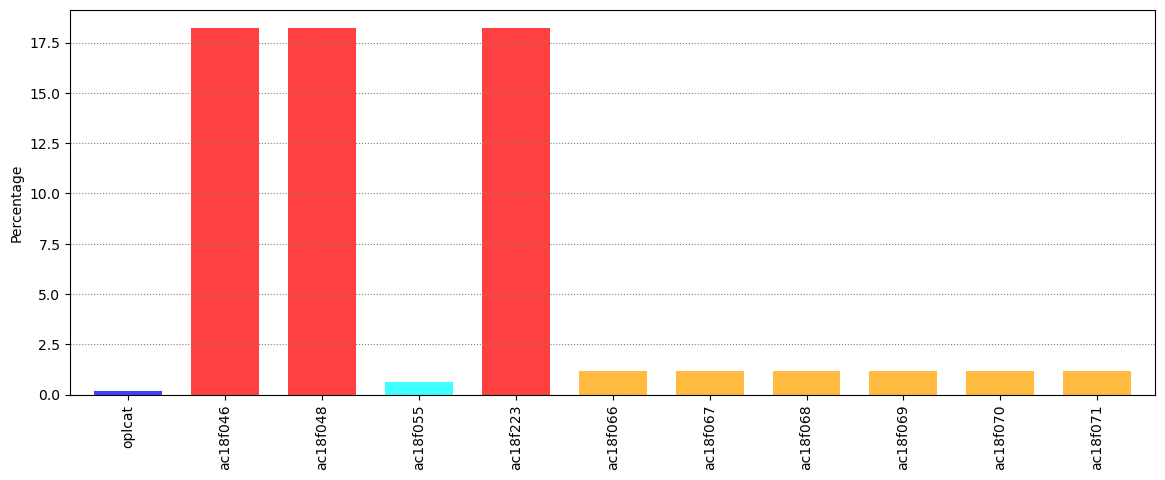

In [359]:
#display missing infomration ratios
missing_ratio = cleaned_df.isna().sum() / len(cleaned_df) * 100

# Filter columns that have any missing values
missing_ratio = missing_ratio[missing_ratio > 0]
print("Percentage of missing data per column:")
print(missing_ratio)

fig, ax = plt.subplots(figsize = (14,5))
missing_ratio.plot(kind='bar', color = ['blue', 'red', 'red', 'cyan', 'red', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange'], alpha = 0.75, width = 0.7)
plt.grid(True, which= 'both', axis='y', linestyle = ':', color='gray')   
plt.ylabel("Percentage") 
plt.show()


In [360]:
#look at unique values in dataset for the detection of outliers
for column in cleaned_df.columns:
    unique_values = cleaned_df[column].unique()
    if len(unique_values) > 10:
        print(f"Unique values in '{column}': {len(unique_values)} unique values")
    else:
        print(f"Unique values in '{column}': {unique_values}")

Unique values in 'geslacht': ['Male', 'Female']
Categories (2, object): ['Female', 'Male']
Unique values in 'leeftijd': 79 unique values
Unique values in 'lftdcat': ['55 - 64 years', '35 - 44 years', '65 years and older', '45 - 54 years', '15 - 24 years', '25 - 34 years']
Categories (7, object): ['14 years and younger', '15 - 24 years', '25 - 34 years', '35 - 44 years', '45 - 54 years', '55 - 64 years', '65 years and older']
Unique values in 'aantalki': ['None', 'Two children', 'Three children', 'One child', 'Four children', 'Five children', 'Six children']
Categories (7, object): ['Five children', 'Four children', 'None', 'One child', 'Six children', 'Three children', 'Two children']
Unique values in 'oplcat': ['hbo (higher vocational education, US: college)', 'wo (university)', 'havo/vwo (higher secondary education/preparat..., 'vmbo (intermediate secondary education, US: j..., 'mbo (intermediate vocational education, US: j..., 'primary school', NaN]
Categories (6, object): ['havo/vw

In [362]:
#impute missing values for education variable
cleaned_df['oplcat'] = cleaned_df['oplcat'].fillna('hbo (higher vocational education, US: college)')

In [363]:
#put data in the correct format and fill in missing information

#for gender column
cleaned_df['geslacht'] = cleaned_df['geslacht'].map({'Female': 1, 'Male': 0})

#for age category column
cleaned_df['lftdcat'] = cleaned_df['lftdcat'].map({'15 - 24 years': 1, '25 - 34 years': 2, '35 - 44 years': 3, '45 - 54 years': 4, '55 - 64 years': 5, '65 years and older': 6, '14 years and younger': 0})

#amount of children
cleaned_df['aantalki'] = cleaned_df['aantalki'].map({'None':0, 'Two children':2, 'Three children':3, 'One child':1, 'Four children':4, 'Five children':5, 'Six children':6})

#for eduction
cleaned_df['oplcat'] = cleaned_df['oplcat'].map({'primary school':1, 'vmbo (intermediate secondary education, US: junior high school)':2, 'havo/vwo (higher secondary education/preparatory university education, US: senior high school)':3, 'mbo (intermediate vocational education, US: junior college)':4, 'hbo (higher vocational education, US: college)':5, 'wo (university)':6})

#for yes/no columns
columns = ['cs17j251', 'cs17j252', 'cs17j253', 'cs17j254', 'cs17j429', 'cs17j430', 'cs17j260', 'cs17j261', 'cs17j262', 'cs17j263', 'cs17j431', 'cs17j432', 'cs17j486', 'cs17j264', 'cs17j435', 'cs17j265', 'cs17j266']

for column in columns :
    cleaned_df[column] = cleaned_df[column].map({'yes': 1, 'no': 0})

category = ['cs17j251', 'cs17j252', 'cs17j253', 'cs17j254','cs17j429', 'cs17j430', 'cs17j260', 'cs17j261', 'cs17j262', 'cs17j263', 'cs17j431', 'cs17j432', 'cs17j486', 'cs17j264', 'cs17j435', 'cs17j265', 'cs17j266', 'geslacht', 'lftdcat', 'aantalki', 'oplcat']

for column in category :
    cleaned_df[column] = cleaned_df[column].astype('int')

#change certain values to 0 category
columns_6 = ["ac18f046", "ac18f047", "ac18f048", "ac18f049", "ac18f050", "ac18f051", "ac18f052", "ac18f053", "ac18f054", "ac18f055"]
for column in columns_6:
    cleaned_df[column] = cleaned_df[column].apply(lambda x: 0 if x == 6 else x)

#98/99 to 0
columns_99 = ["ac18f126", "ac18f044", "ac18f045", "ac18f220"]
for column in columns_99:
    cleaned_df[column] = cleaned_df[column].apply(lambda x: 0 if x == 99 or x == 98 else x)

#fill in missing information of certain columns
cleaned_df = cleaned_df.fillna({"ac18f046": 0, "ac18f048": 0, "ac18f055": 0, 'ac18f066': 4, 'ac18f067': 4,'ac18f068': 4,'ac18f069': 4, 'ac18f070': 4, 'ac18f071': 4, 'ac18f223':2})

cleaned_df.head()

geslacht  leeftijd  lftdcat  aantalki  oplcat  ac18f092  ac18f007  \
0         0      62.0        5         0       5         1         3   
1         0      55.0        5         2       6         1         1   
2         1      42.0        3         2       3         2         1   
3         1      71.0        6         0       2         1         4   
4         0      43.0        3         3       6         3         1   

   ac18f036  ac18f126  ac18f044  ...  cs17j261  cs17j262  cs17j263  cs17j431  \
0      10.0       3.0       1.0  ...         0         1         1         1   
1       6.0       1.0       1.0  ...         0         1         0         1   
2       8.0       3.0       1.0  ...         0         1         0         1   
3       1.0       4.0       1.0  ...         1         1         1         1   
4       9.0       1.0       1.0  ...         1         1         1         1   

   cs17j432  cs17j486  cs17j264  cs17j435  cs17j265  cs17j266  
0         1         1         1         0         1         1  
1         1         0         0         0         0         0  
2         0         1         1         0         0         1  
3         0         1         0         0         0         0  
4         1         1         1         0         1         1  

[5 rows x 68 columns]

In [364]:
#final check on data
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5219 entries, 0 to 5435
Data columns (total 68 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   geslacht  5219 non-null   int32  
 1   leeftijd  5219 non-null   float64
 2   lftdcat   5219 non-null   int32  
 3   aantalki  5219 non-null   int32  
 4   oplcat    5219 non-null   int32  
 5   ac18f092  5219 non-null   int64  
 6   ac18f007  5219 non-null   int64  
 7   ac18f036  5219 non-null   float64
 8   ac18f126  5219 non-null   float64
 9   ac18f044  5219 non-null   float64
 10  ac18f045  5219 non-null   float64
 11  ac18f220  5219 non-null   float64
 12  ac18f046  5219 non-null   float64
 13  ac18f047  5219 non-null   float64
 14  ac18f048  5219 non-null   float64
 15  ac18f049  5219 non-null   float64
 16  ac18f050  5219 non-null   float64
 17  ac18f051  5219 non-null   float64
 18  ac18f052  5219 non-null   float64
 19  ac18f053  5219 non-null   float64
 20  ac18f054  5219 non-null   float64
 

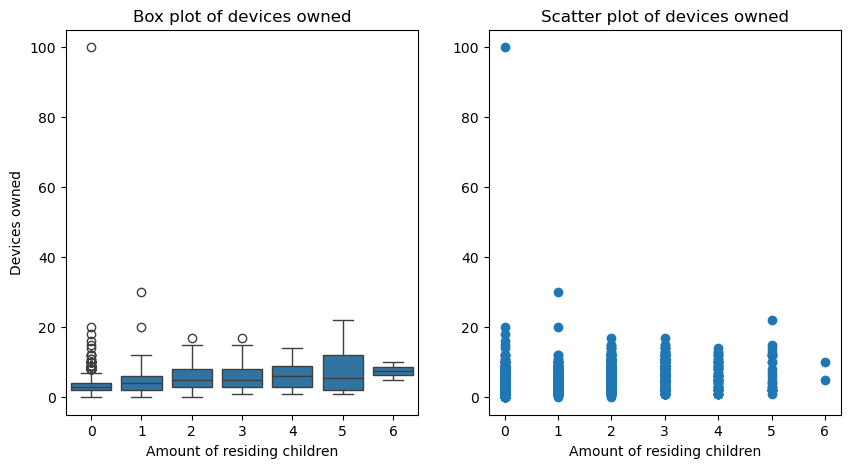

In [365]:
#outlier visualisation of computers owned column
plt.figure(figsize=(10, 5))

# Box plot
plt.subplot(1, 2, 1)
sns.boxplot(x='aantalki', y='ac18f036', data=cleaned_df)
plt.ylabel('Devices owned')
plt.xlabel('Amount of residing children')
plt.title('Box plot of devices owned')

#scatterplot
plt.subplot(1, 2, 2)
plt.scatter(cleaned_df['aantalki'], cleaned_df['ac18f036'])
plt.title('Scatter plot of devices owned')
plt.xlabel('Amount of residing children')

plt.show()

In [366]:
# remove outliers usign IQR
def remove_outliers(group):
    Q1 = group['ac18f036'].quantile(0.25)
    Q3 = group['ac18f036'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out outliers
    filtered_group = group[(group['ac18f036'] >= lower_bound) & (group['ac18f036'] <= upper_bound)]
    
    return filtered_group

# Group by 'aantalki' and apply the outlier removal function
grouped = cleaned_df.groupby('aantalki')
cleaned_df = grouped.apply(remove_outliers).reset_index(drop=True)


In [368]:
#change data to integer format
for column in cleaned_df.columns:
    if pd.api.types.is_numeric_dtype(cleaned_df[column]):
        cleaned_df[column] = cleaned_df[column].astype(int)

print(cleaned_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5150 entries, 0 to 5149
Data columns (total 68 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   geslacht  5150 non-null   int32
 1   leeftijd  5150 non-null   int32
 2   lftdcat   5150 non-null   int32
 3   aantalki  5150 non-null   int32
 4   oplcat    5150 non-null   int32
 5   ac18f092  5150 non-null   int32
 6   ac18f007  5150 non-null   int32
 7   ac18f036  5150 non-null   int32
 8   ac18f126  5150 non-null   int32
 9   ac18f044  5150 non-null   int32
 10  ac18f045  5150 non-null   int32
 11  ac18f220  5150 non-null   int32
 12  ac18f046  5150 non-null   int32
 13  ac18f047  5150 non-null   int32
 14  ac18f048  5150 non-null   int32
 15  ac18f049  5150 non-null   int32
 16  ac18f050  5150 non-null   int32
 17  ac18f051  5150 non-null   int32
 18  ac18f052  5150 non-null   int32
 19  ac18f053  5150 non-null   int32
 20  ac18f054  5150 non-null   int32
 21  ac18f055  5150 non-null   int32
 22  

# Save clean dataset

In [369]:
cleaned_df.to_csv('final_data.csv', index=False)

### load cleaned dataset

In [370]:
data = pd.read_csv('final_data.csv')

### Split labels and parameters

In [371]:
parameters = data.drop(["ac18f279", "ac18f280", "ac18f281", "ac18f282", "ac18f221", "ac18f222", "ac18f223", "ac18f224", "ac18f225" ,"ac18f226", "ac18f285"], axis= 1)
labels = data[["ac18f279", "ac18f280", "ac18f281", "ac18f282", "ac18f221", "ac18f222", "ac18f223", "ac18f224", "ac18f225" ,"ac18f226", "ac18f285"]]

### Creation of preprocessor for pipeline

In [372]:
#Transform ceratain labels using OneHotEncoder

# Define which columns to OneHotEncode and which to passthrough
onehot_cols = ['ac18f092', 'ac18f007', 'ac18f045', 'ac18f066', 'ac18f067', 'ac18f069', 'ac18f070', 'ac18f071', 'ac18f080', 'ac18f081', 'ac18f082', 'ac18f083', 'ac18f084', 'ac18f085', 'ac18f087', 'ac18f088', 'ac18f089', 'ac18f090', 'ac18f091']

# Create ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), onehot_cols)
    ],
    remainder='passthrough'
)

In [373]:
#change labels to correct format
columns_binary = ['ac18f221', 'ac18f222',	'ac18f223',	'ac18f224',	'ac18f225',	'ac18f226',	'ac18f285']
for column in columns_binary:
    # Replace values higher than 1 with 0 in the current column
    labels.loc[:, column] = labels[column].apply(lambda x: 0 if x > 1 else x)

#malware labels
columns_malware = ['ac18f279',  'ac18f280',  'ac18f281',  'ac18f282']
for column in columns_malware:
    # Replace values higher than 1 with 0 in the current column
    labels.loc[:, column] = labels[column].apply(lambda x: 0 if x == 1 or x == 6 else x)

labels['malware'] = labels[columns_malware].apply(lambda x: all(i > 0 for i in x), axis=1).astype(int)

print(labels.head())
print(labels['malware'].value_counts())

   ac18f279  ac18f280  ac18f281  ac18f282  ac18f221  ac18f222  ac18f223  \
0         4         2         0         0         0         0         0   
1         5         4         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         2         0         0         0         0         0         0   
4         3         0         2         2         0         0         0   

   ac18f224  ac18f225  ac18f226  ac18f285  malware  
0         0         0         0         0        0  
1         0         0         0         0        0  
2         0         0         0         0        0  
3         0         0         0         0        0  
4         0         0         0         0        0  
malware
0    4865
1     285
Name: count, dtype: int64


C:\Users\samsm\AppData\Local\Temp\ipykernel_20628\3650888978.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['malware'] = labels[columns_malware].apply(lambda x: all(i > 0 for i in x), axis=1).astype(int)


# EDA graphs of the data

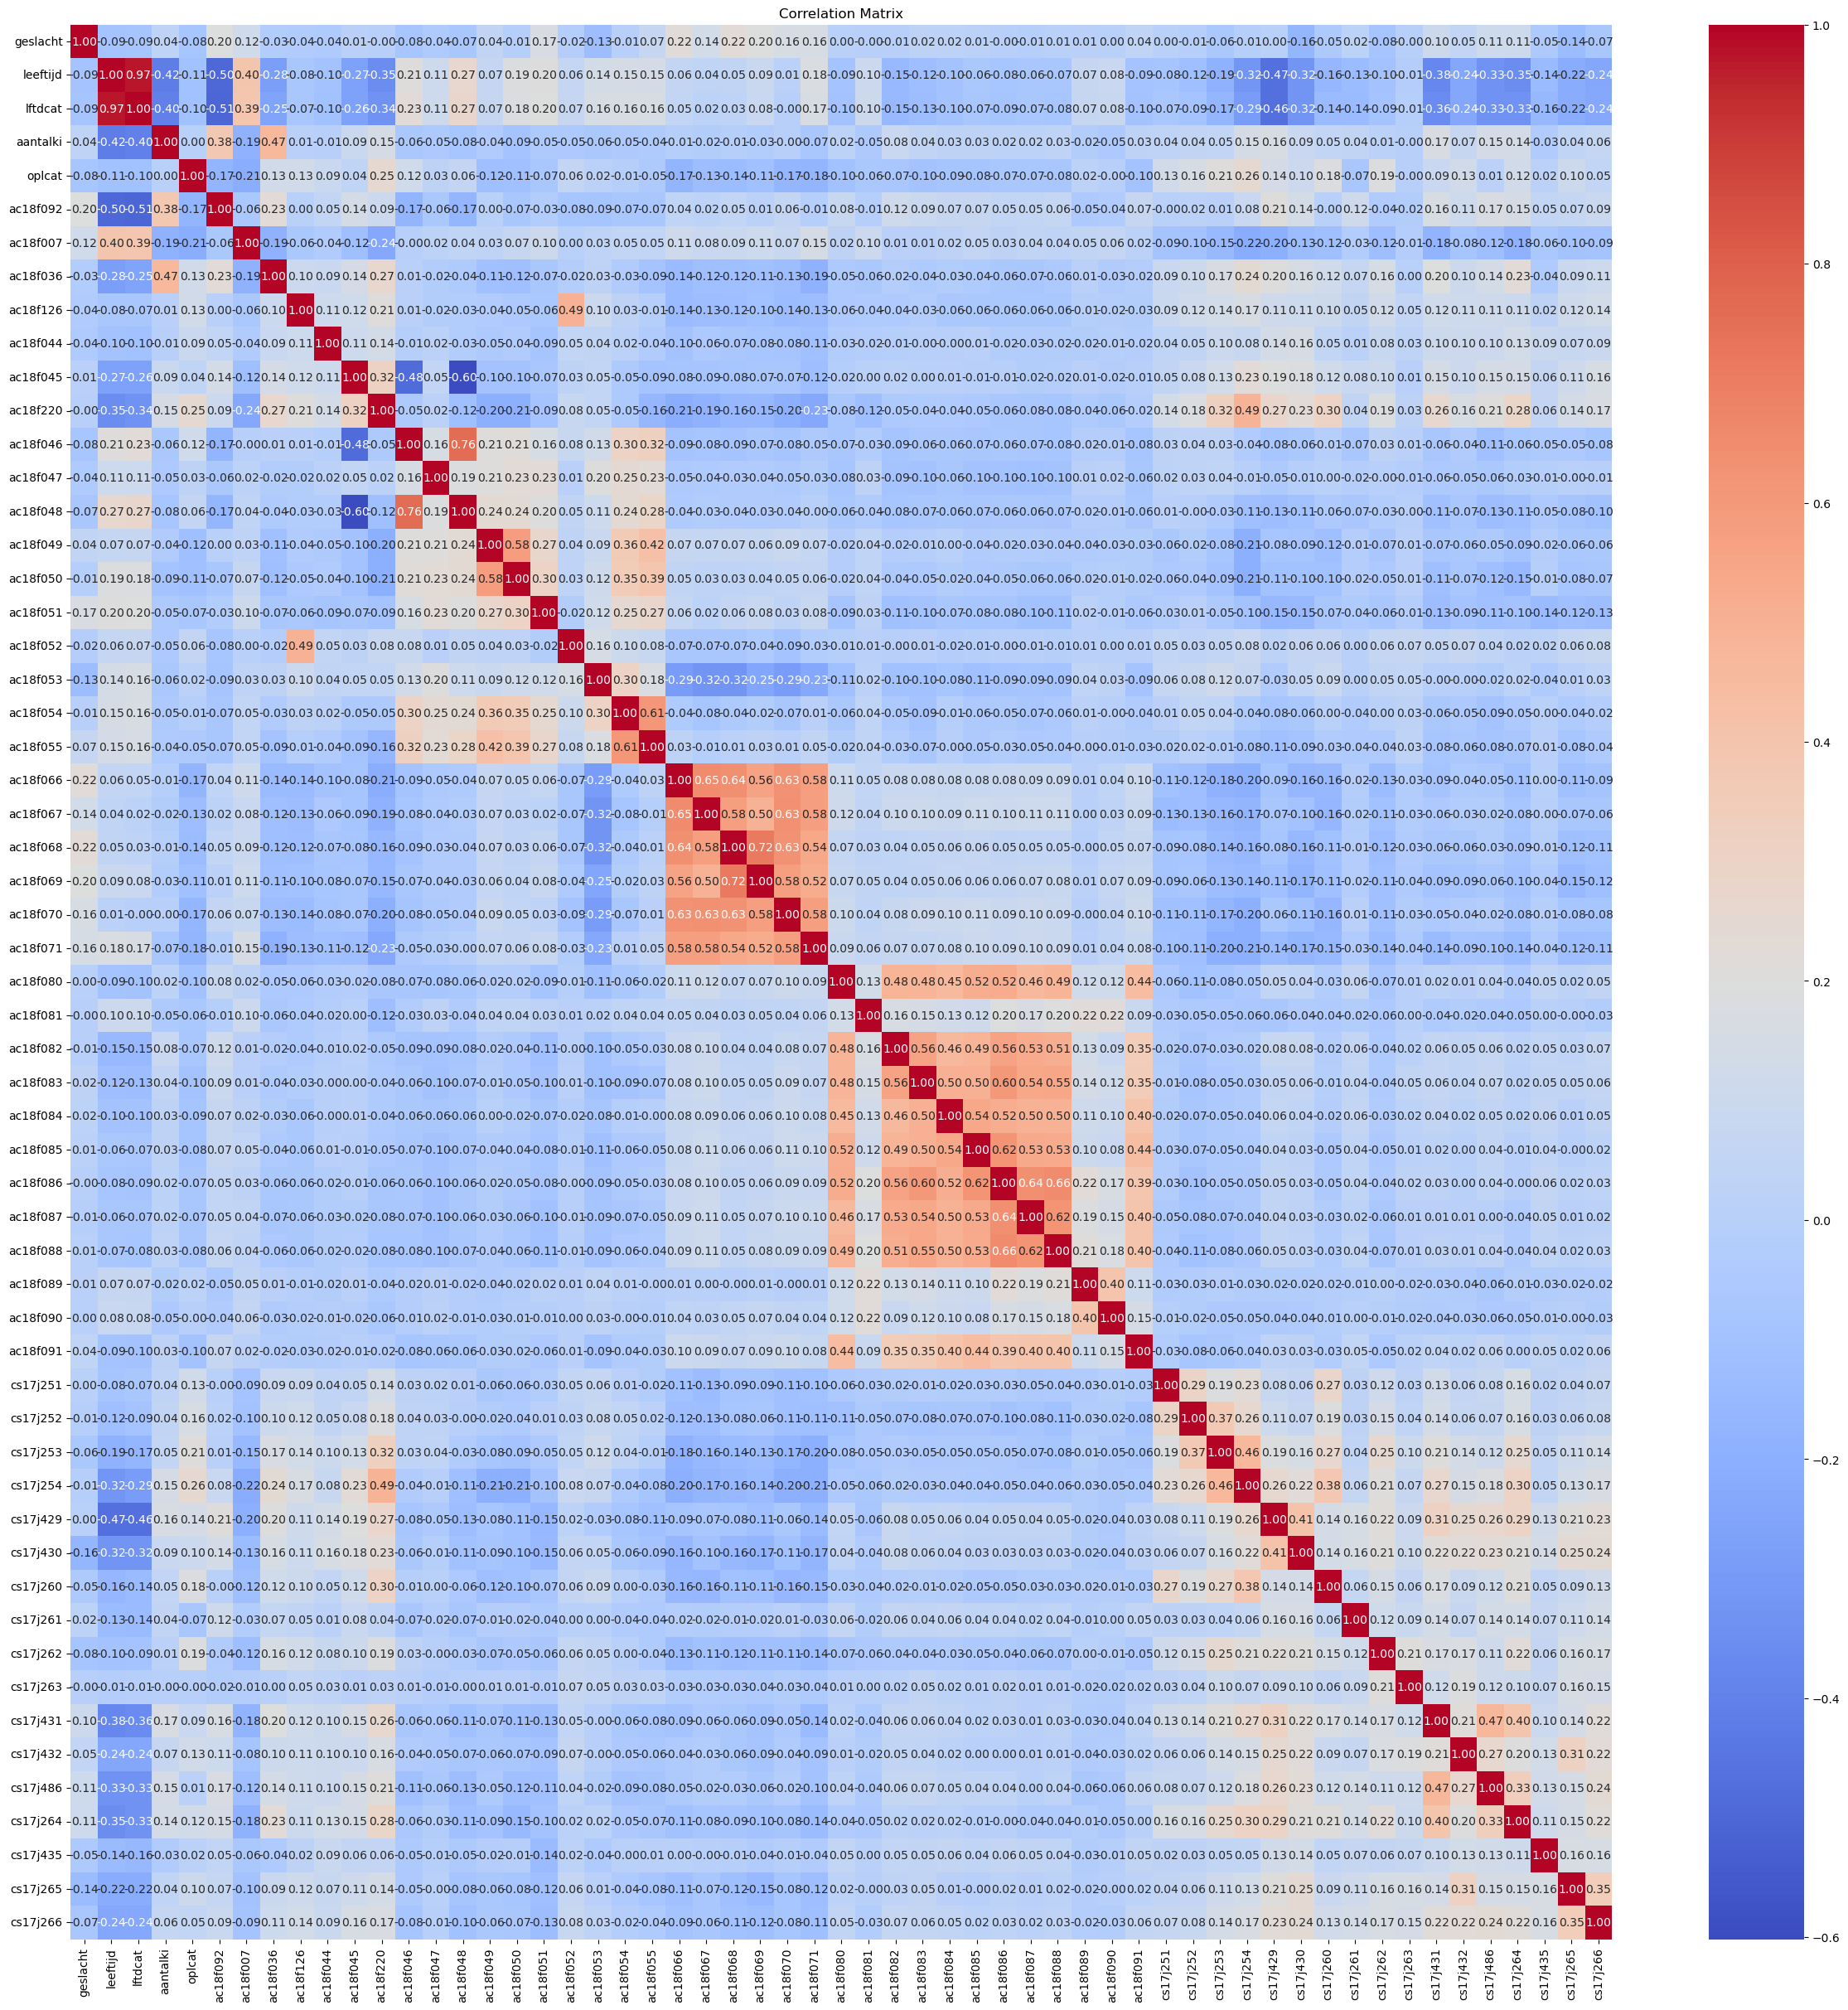

In [374]:
#correlation matrix of the parameters
correlation_matrix = parameters.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

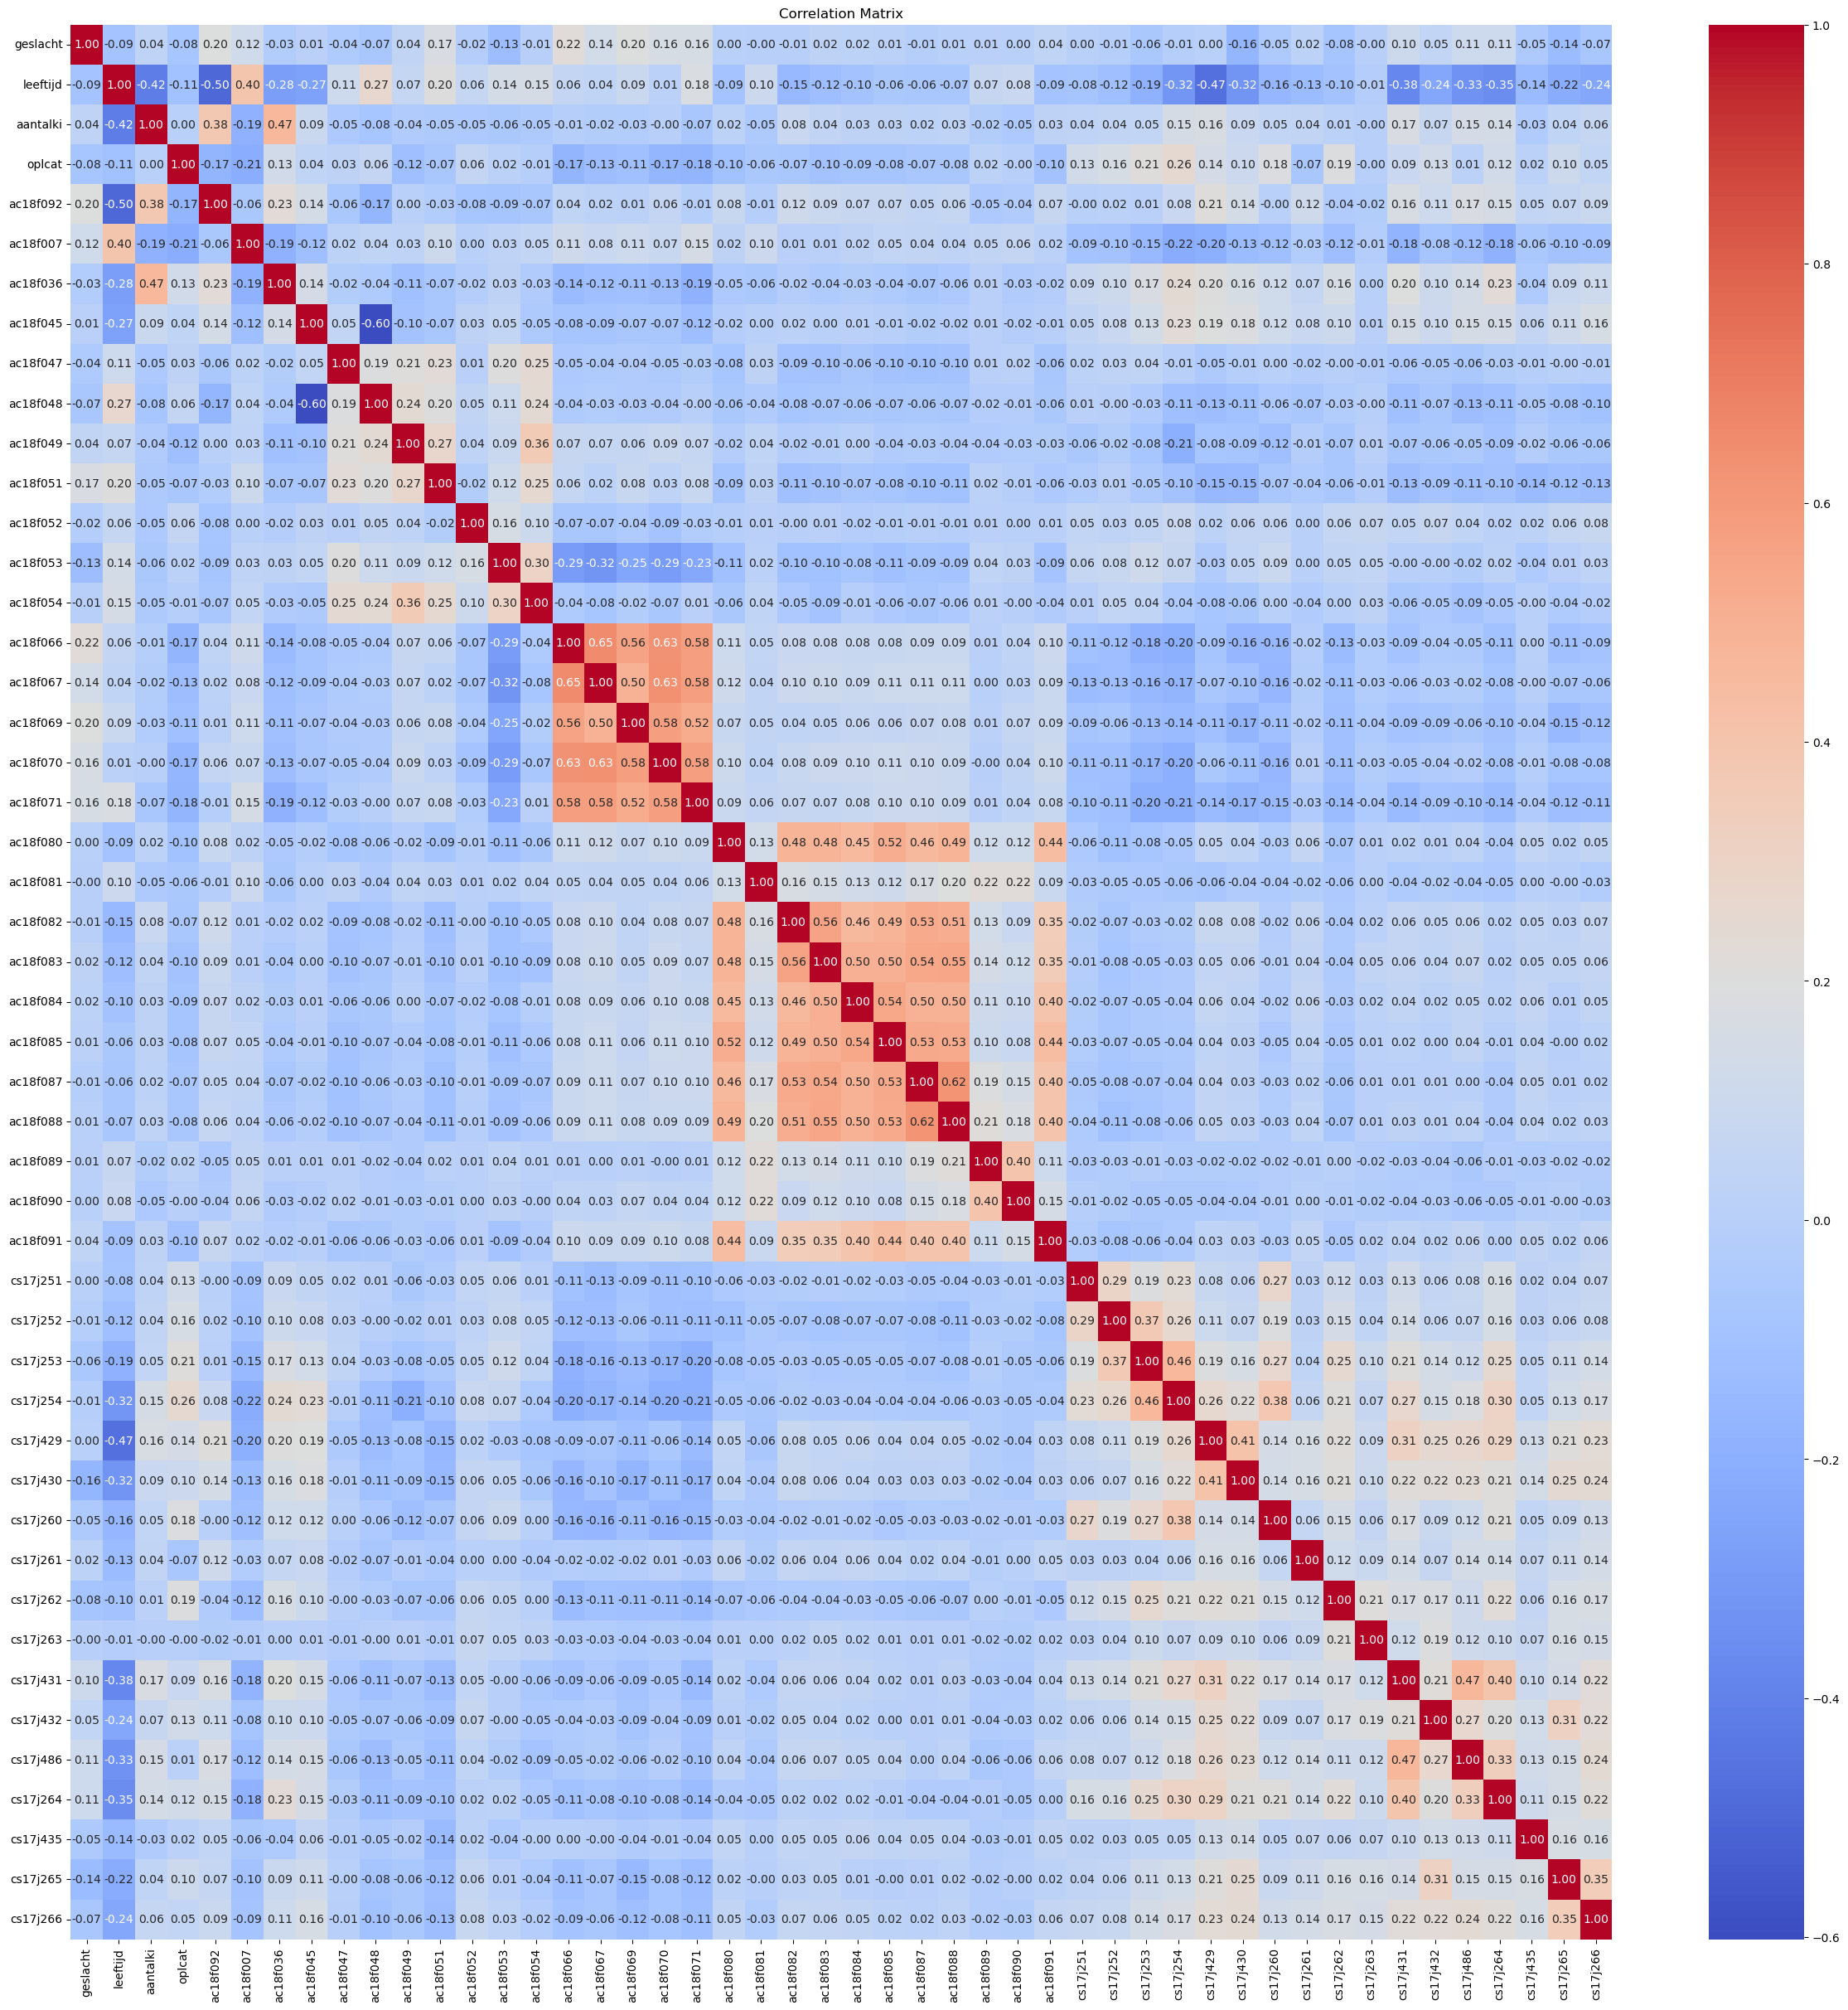

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5150 entries, 0 to 5149
Data columns (total 48 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   geslacht  5150 non-null   int64
 1   leeftijd  5150 non-null   int64
 2   aantalki  5150 non-null   int64
 3   oplcat    5150 non-null   int64
 4   ac18f092  5150 non-null   int64
 5   ac18f007  5150 non-null   int64
 6   ac18f036  5150 non-null   int64
 7   ac18f045  5150 non-null   int64
 8   ac18f047  5150 non-null   int64
 9   ac18f048  5150 non-null   int64
 10  ac18f049  5150 non-null   int64
 11  ac18f051  5150 non-null   int64
 12  ac18f052  5150 non-null   int64
 13  ac18f053  5150 non-null   int64
 14  ac18f054  5150 non-null   int64
 15  ac18f066  5150 non-null   int64
 16  ac18f067  5150 non-null   int64
 17  ac18f069  5150 non-null   int64
 18  ac18f070  5150 non-null   int64
 19  ac18f071  5150 non-null   int64
 20  ac18f080  5150 non-null   int64
 21  ac18f081  5150 non-null   int64
 22  

In [375]:
#remove further columns which are highly corellated and check again. 
parameters = parameters.drop(['ac18f126', 'lftdcat', 'ac18f046', 'ac18f050', 'ac18f055', 'ac18f068', 'ac18f220','ac18f086', 'ac18f044'], axis= 1)

correlation_matrix = parameters.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

print(parameters.info())

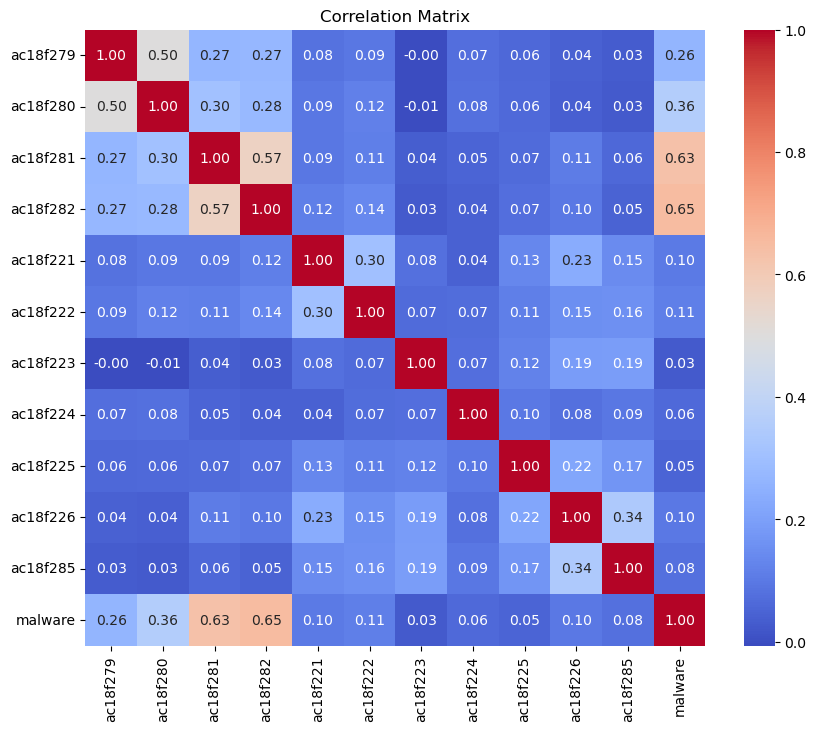

In [377]:
#correlation matrix of labels
correlation_matrix = labels.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

[1.6893203883495145, 2.6990291262135924, 1.262135922330097, 5.242718446601942, 1.9611650485436893, 0.6407766990291262, 0.6019417475728156, 5.533980582524272]


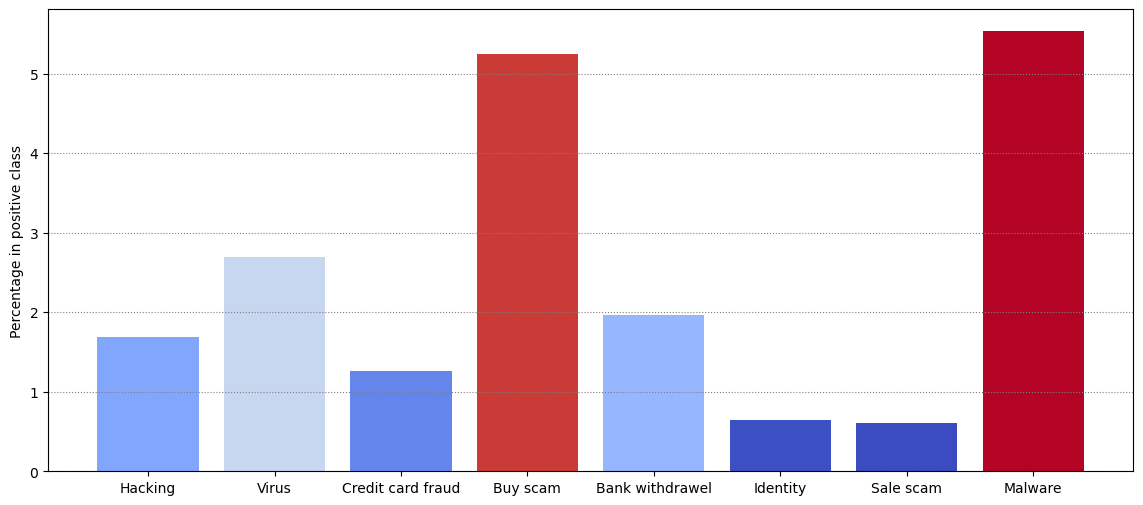

In [378]:
#Create label ratio imbalance 
labels_8 = labels[['ac18f221', 'ac18f222',	'ac18f223',	'ac18f224',	'ac18f225',	'ac18f226',	'ac18f285', 'malware']]
ratio_list = []

for label in labels_8 :
    ratio_list.append(labels_8[label].sum()/len(labels_8)*100)

print(ratio_list)

normalized_values = (ratio_list - np.min(ratio_list)) / (np.max(ratio_list) - np.min(ratio_list))

color_map = plt.get_cmap('coolwarm')

colors = color_map(normalized_values)

labels_display = ['Hacking', 'Virus', 'Credit card fraud',	'Buy scam',	'Bank withdrawel', 'Identity',	'Sale scam', 'Malware']

fig, ax = plt.subplots(figsize = (14,6))
ax.bar(labels_display, ratio_list, color = colors)
plt.grid(True, which= 'both', axis='y', linestyle = ':', color='gray')
plt.ylabel("Percentage in positive class")
plt.show()


### Multi-label classification with 8 labels

In [122]:
labels_8 = labels[['ac18f221', 'ac18f222',	'ac18f223',	'ac18f224',	'ac18f225',	'ac18f226',	'ac18f285', 'malware']]
X_train, X_test, y_train, y_test = train_test_split(parameters, labels_8, test_size=0.2, random_state=random_state)
y_train.head()

ac18f221  ac18f222  ac18f223  ac18f224  ac18f225  ac18f226  ac18f285  \
1330       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2951       0.0       0.0       0.0       1.0       0.0       0.0       0.0   
3298       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4842       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2025       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

      malware  
1330        0  
2951        1  
3298        0  
4842        0  
2025        0

### MLSMOTE

In [123]:
#MLSMOTE
import numpy as np
import pandas as pd
import random
from sklearn.neighbors import NearestNeighbors

def get_tail_label(df):
    """
    Give tail label colums of the given target dataframe
    
    args
    df: pandas.DataFrame, target label df whose tail label has to identified
    
    return
    tail_label: list, a list containing column name of all the tail label
    """
    columns = df.columns
    n = len(columns)
    irpl = np.zeros(n)
    for column in range(n):
        irpl[column] = df[columns[column]].value_counts()[1]
    irpl = max(irpl)/irpl
    mir = np.average(irpl)
    tail_label = []
    for i in range(n):
        if irpl[i] > mir:
            tail_label.append(columns[i])
    return tail_label

def get_index(df):
  """
  give the index of all tail_label rows
  args
  df: pandas.DataFrame, target label df from which index for tail label has to identified
    
  return
  index: list, a list containing index number of all the tail label
  """
  tail_labels = get_tail_label(df)
  index = set()
  for tail_label in tail_labels:
    sub_index = set(df[df[tail_label]==1].index)
    index = index.union(sub_index)
  return list(index)

def get_minority_instace(X, y):
    """
    Give minority dataframe containing all the tail labels
    
    args
    X: pandas.DataFrame, the feature vector dataframe
    y: pandas.DataFrame, the target vector dataframe
    
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    index = get_index(y)
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X):
    """
    Give index of 5 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs=NearestNeighbors(n_neighbors=5,metric='euclidean',algorithm='kd_tree').fit(X)
    euclidean,indices= nbs.kneighbors(X)
    return indices

def MLSMOTE(X,y, n_sample):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0,n-1)
        neighbour = random.choice(indices2[reference,1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val>2 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbour,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    new_X = pd.concat([X, new_X], axis=0)
    target = pd.concat([y, target], axis=0)
    return new_X, target

if __name__=='__main__':
    """
    main function to use the MLSMOTE
    """
    X_sub, y_sub = get_minority_instace(X_train, y_train)   #Getting minority instance of that datframe
    X_res,y_res =MLSMOTE(X_sub, y_sub, 1000)     #Applying MLSMOTE to augment the dataframe

In [124]:
#MLSMOTE logistic regression

classifier = LabelPowerset(LogisticRegression(max_iter=3000))

# create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_res, y_res)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

y_pred = predictions
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.01195219123505976
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.02      0.06      0.03        18
           2       0.01      1.00      0.01         4
           3       0.11      0.11      0.11        73
           4       0.00      0.00      0.00        16
           5       0.01      0.20      0.01         5
           6       0.01      0.50      0.02         4
           7       0.25      0.02      0.04        47

   micro avg       0.01      0.09      0.02       181
   macro avg       0.05      0.24      0.03       181
weighted avg       0.11      0.09      0.06       181
 samples avg       0.01      0.02      0.01       181



c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [116]:
#lpros logistic regression
classifier = LogisticRegression(max_iter=3000)

#Randomoversampler for the data
lp = LabelPowerset()
ros = RandomOverSampler(random_state=random_state)

yt = lp.transform(y_train)

X_resampled, y_resampled = ros.fit_resample(X_train, yt)

# create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

y_pred = lp.inverse_transform(predictions)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.22030651340996169
Classification Report:
              precision    recall  f1-score   support

           0       0.01      0.13      0.03        15
           1       0.03      0.17      0.05        29
           2       0.00      0.00      0.00        12
           3       0.08      0.37      0.13        49
           4       0.03      0.13      0.05        23
           5       0.03      0.14      0.04         7
           6       0.00      0.00      0.00         9
           7       0.07      0.25      0.11        57

   micro avg       0.04      0.21      0.07       201
   macro avg       0.03      0.15      0.05       201
weighted avg       0.05      0.21      0.08       201
 samples avg       0.03      0.04      0.03       201



c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [115]:
#LPROS with random forest
classifier = RandomForestClassifier(n_estimators=1000, random_state=42)

#Randomoversampler for the data
lp = LabelPowerset()
ros = RandomOverSampler(random_state=42)

yt = lp.transform(y_train)

X_resampled, y_resampled = ros.fit_resample(X_train, yt)

# create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

y_pred = lp.inverse_transform(predictions)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.8496168582375478
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.00      0.00      0.00        29
           2       0.00      0.00      0.00        12
           3       0.00      0.00      0.00        49
           4       0.00      0.00      0.00        23
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         9
           7       0.00      0.00      0.00        57

   micro avg       0.00      0.00      0.00       201
   macro avg       0.00      0.00      0.00       201
weighted avg       0.00      0.00      0.00       201
 samples avg       0.00      0.00      0.00       201



### Multi-label classification with the deliton of 226 and 285 - 6 labels in total

In [119]:
labels_6 = labels[['ac18f221', 'ac18f222',	'ac18f223',	'ac18f224',	'ac18f225', 'malware']]
X_train, X_test, y_train, y_test = train_test_split(parameters, labels_6, test_size=0.2, random_state=random_state)
X_train.head()

geslacht  leeftijd  aantalki  oplcat  ac18f092  ac18f007  ac18f036  \
927          0      72.0         0       4         1         8       3.0   
2499         0      38.0         1       4         1         1       2.0   
45           1      47.0         3       5         2         1      10.0   
1741         0      63.0         0       6         1         1       2.0   
2275         0      33.0         0       4         1         1       4.0   

      ac18f045  ac18f047  ac18f048  ...  cs17j261  cs17j262  cs17j263  \
927        1.0       2.0       5.0  ...         0         0         0   
2499       2.0       3.0       3.0  ...         1         1         0   
45         2.0       4.0       2.0  ...         0         0         0   
1741       2.0       3.0       3.0  ...         0         1         0   
2275       2.0       5.0       3.0  ...         0         0         0   

      cs17j431  cs17j432  cs17j486  cs17j264  cs17j435  cs17j265  cs17j266  
927          0         0         0         0         0         0         0  
2499         0         0         0         0         0         0         0  
45           1         1         0         1         0         0         0  
1741         0         0         1         1         0         0         1  
2275         1         1         1         1         0         0         1  

[5 rows x 48 columns]

In [120]:
#lpros logistic regression
classifier = LogisticRegression()

#Randomoversampler for the data
lp = LabelPowerset()
ros = RandomOverSampler(random_state=42)

yt = lp.transform(y_train)

X_resampled, y_resampled = ros.fit_resample(X_train, yt)

# create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

y_pred = lp.inverse_transform(predictions)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.10440613026819924
Classification Report:
              precision    recall  f1-score   support

           0       0.01      0.13      0.01        15
           1       0.01      0.14      0.02        29
           2       0.01      0.25      0.03        12
           3       0.07      0.39      0.12        49
           4       0.02      0.22      0.04        23
           5       0.07      0.26      0.11        57

   micro avg       0.03      0.26      0.06       185
   macro avg       0.03      0.23      0.06       185
weighted avg       0.05      0.26      0.08       185
 samples avg       0.03      0.04      0.03       185



c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Multi-label classification with 4 of the labels. 
Deletion of 221 and 223

In [121]:
labels_4 = labels[['ac18f222', 'ac18f224',	'ac18f225', 'malware']]
X_train, X_test, y_train, y_test = train_test_split(parameters, labels_4, test_size=0.2, random_state=random_state)
y_train.head()

ac18f222  ac18f224  ac18f225  malware
927        0.0       0.0       0.0        0
2499       0.0       0.0       0.0        0
45         0.0       0.0       0.0        0
1741       0.0       0.0       0.0        0
2275       0.0       0.0       0.0        0

In [122]:
#lpros logistic regression
classifier = LogisticRegression(max_iter=600)

#Randomoversampler for the data
lp = LabelPowerset()
ros = RandomOverSampler(random_state=42)

yt = lp.transform(y_train)

X_resampled, y_resampled = ros.fit_resample(X_train, yt)

# create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

y_pred = lp.inverse_transform(predictions)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.27586206896551724
Classification Report:
              precision    recall  f1-score   support

           0       0.03      0.21      0.05        29
           1       0.07      0.39      0.12        49
           2       0.01      0.13      0.03        23
           3       0.06      0.28      0.10        57

   micro avg       0.05      0.28      0.08       158
   macro avg       0.04      0.25      0.07       158
weighted avg       0.05      0.28      0.09       158
 samples avg       0.03      0.04      0.03       158



c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [123]:
#LPros with randomforests
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

#Randomoversampler for the data
lp = LabelPowerset()
ros = RandomOverSampler(random_state=42)

yt = lp.transform(y_train)

X_resampled, y_resampled = ros.fit_resample(X_train, yt)

# create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

y_pred = lp.inverse_transform(predictions)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.8687739463601533
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.00      0.00      0.00        49
           2       0.00      0.00      0.00        23
           3       0.67      0.04      0.07        57

   micro avg       0.67      0.01      0.02       158
   macro avg       0.17      0.01      0.02       158
weighted avg       0.24      0.01      0.02       158
 samples avg       0.00      0.00      0.00       158



### Only two labels. 
Cybercrime victim and malware

In [63]:
#create new column
labels['victim'] = labels[['ac18f221', 'ac18f222',	'ac18f223',	'ac18f224',	'ac18f225',	'ac18f226',	'ac18f285']].sum(axis= 1)

labels['victim'] = labels['victim'].apply(lambda x: 1 if x >= 1 else x)

y = labels["victim"]
print(y.value_counts())

victim
0.0    4639
1.0     577
Name: count, dtype: int64


C:\Users\samsm\AppData\Local\Temp\ipykernel_17664\3579921424.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['victim'] = labels[['ac18f221', 'ac18f222',	'ac18f223',	'ac18f224',	'ac18f225',	'ac18f226',	'ac18f285']].sum(axis= 1)
C:\Users\samsm\AppData\Local\Temp\ipykernel_17664\3579921424.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['victim'] = labels['victim'].apply(lambda x: 1 if x >= 1 else x)


In [64]:
#select two labels
labels_2 = labels[['malware', 'victim']]
labels_2.head()

malware  victim
0        0     0.0
1        0     0.0
2        0     0.0
3        0     0.0
4        0     0.0

In [65]:
#split data
X_train, X_test, y_train, y_test = train_test_split(parameters, labels_2, test_size=0.2, stratify= labels_2, random_state=random_state)
y_train.head()

malware  victim
976         0     0.0
604         0     0.0
17          0     1.0
1726        0     0.0
5028        0     1.0

In [66]:
#lpros logistic regression
classifier = LogisticRegression(max_iter=5000)

#Randomoversampler for the data
lp = LabelPowerset()
ros = RandomOverSampler(random_state=42)

yt = lp.transform(y_train)

X_resampled, y_resampled = ros.fit_resample(X_train, yt)

# create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

y_pred = lp.inverse_transform(predictions)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.4166666666666667
Classification Report:
              precision    recall  f1-score   support

           0       0.07      0.41      0.12        58
           1       0.14      0.47      0.21       116

   micro avg       0.10      0.45      0.17       174
   macro avg       0.10      0.44      0.16       174
weighted avg       0.11      0.45      0.18       174
 samples avg       0.06      0.07      0.06       174



In [179]:
#LPros with randomforests
classifier = RandomForestClassifier(n_estimators=1000, random_state=42)

#Randomoversampler for the data
lp = LabelPowerset()
ros = RandomOverSampler(random_state=42)

yt = lp.transform(y_train)

X_resampled, y_resampled = ros.fit_resample(X_train, yt)

# create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

y_pred = lp.inverse_transform(predictions)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.8467432950191571
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        58
           1       0.00      0.00      0.00       116

   micro avg       0.00      0.00      0.00       174
   macro avg       0.00      0.00      0.00       174
weighted avg       0.00      0.00      0.00       174
 samples avg       0.00      0.00      0.00       174



In [184]:
#multi label perceptron for two labels

X_train, X_test, y_train, y_test = train_test_split(parameters, labels_2, test_size=0.2, stratify= labels_2, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)

def create_model():
    model = models.Sequential([
        layers.Dense(256, activation='relu', input_shape=(103,)),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(2, activation='sigmoid')  # Assuming 8 output labels for multi-label classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['f1_score'])
    return model

classifier = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=1)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Since the output is sigmoid, we need to threshold it to get binary labels

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Epoch 1/20


c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - f1_score: 0.1432 - loss: 0.3759
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.1339 - loss: 0.2644
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.1070 - loss: 0.2689
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.1276 - loss: 0.2742
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.1727 - loss: 0.2795
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.1956 - loss: 0.2532
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.1940 - loss: 0.2625
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.1915 - loss: 0.2761
Epoch 9/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - f1_score: 0.2151 - loss: 0.2496
Epoch 10/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.2131 - loss: 0.2584
Epoch 11/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.2574 - loss: 0.2375
Epoch 12/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - f1_score: 0.2255 - loss: 0.2512


## With label 224 and malware

In [32]:
labels_2 = labels_8[['ac18f224', 'malware']]
X_train, X_test, y_train, y_test = train_test_split(parameters, labels_2, test_size=0.2, stratify= labels_2, random_state=random_state)
y_train.head()

ac18f224  malware
809        0.0        0
2095       1.0        0
4325       0.0        0
4316       0.0        0
5094       0.0        0

In [41]:
#lpros logistic regression -> try to optimalize this
classifier = LogisticRegression(solver= "liblinear", max_iter= 5000, C=1, penalty='l2')

#Randomoversampler for the data
lp = LabelPowerset()
ros = RandomOverSampler(random_state=42)

yt = lp.transform(y_train.values)

X_resampled, y_resampled = ros.fit_resample(X_train, yt)

# create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

y_pred = lp.inverse_transform(predictions)
y_pred_df = pd.DataFrame(y_pred.toarray(), columns=y_train.columns)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_df)
print("Accuracy:", accuracy)

f1_macro = f1_score(y_test, y_pred_df, average='macro')
print(f1_macro)

Accuracy: 0.4339080459770115
0.13546648986829574


### binary task for malware

In [133]:
# select malware label
malware = labels['malware']
X_train, X_test, y_train, y_test = train_test_split(parameters, malware, test_size=0.2, stratify= malware, random_state=random_state)
y_train.head()

4449    0
4478    0
461     0
561     1
4105    0
Name: malware, dtype: int32

In [136]:
#lpros logistic regression
classifier = LogisticRegression(max_iter=5000)

#Randomoversampler for the data
ros = RandomOverSampler(random_state=42)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

y_pred = predictions
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

f1score = f1_score(y_test, y_pred)
print("F1 Score:", f1score)

Accuracy: 0.7155172413793104
F1 Score: 0.17270194986072424


In [153]:
#lpros RF
classifier = RandomForestClassifier(n_estimators=1000, random_state=random_state)

#Randomoversampler for the data
ros = RandomOverSampler(random_state=42)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

y_pred = np.round(predictions)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

f1score = f1_score(y_test, y_pred)
print("F1 Score:", f1score)

Accuracy: 0.946360153256705
F1 Score: 0.0967741935483871


In [156]:
# random oversampler with svm
classifier = svm.SVC()

#Randomoversampler for the data
ros = RandomOverSampler(random_state=42)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

y_pred = np.round(predictions)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

f1score = f1_score(y_test, y_pred)
print("F1 Score:", f1score)

Accuracy: 0.7174329501915708
F1 Score: 0.16901408450704225


### binary with victim as column
This excludes malware victimisatino

In [163]:
victim = labels['victim']
X_train, X_test, y_train, y_test = train_test_split(parameters, victim, test_size=0.2, stratify= victim, random_state=random_state)
y_train.head()

721     0.0
2014    0.0
4042    1.0
1033    1.0
558     0.0
Name: victim, dtype: float64

In [164]:
#lpros logistic regression
classifier = LogisticRegression(max_iter=5000)

#Randomoversampler for the data
ros = RandomOverSampler(random_state=42)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

y_pred = predictions
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

f1score = f1_score(y_test, y_pred)
print("F1 Score:", f1score)

Accuracy: 0.6293103448275862
F1 Score: 0.2684310018903592


In [165]:
#lpros RF
classifier = RandomForestClassifier(n_estimators=100, random_state=random_state)

#Randomoversampler for the data
ros = RandomOverSampler(random_state=42)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

y_pred = np.round(predictions)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

f1score = f1_score(y_test, y_pred)
print("F1 Score:", f1score)

Accuracy: 0.8908045977011494
F1 Score: 0.017241379310344827


In [166]:
# random oversampler with svm
classifier = svm.SVC()

#Randomoversampler for the data
ros = RandomOverSampler(random_state=42)

X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test set
predictions = pipeline.predict(X_test)

y_pred = np.round(predictions)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

f1score = f1_score(y_test, y_pred)
print("F1 Score:", f1score)

Accuracy: 0.5488505747126436
F1 Score: 0.22148760330578512


### Binary of victimisation including malware victimisation

In [379]:
labels['all'] = labels[['ac18f221', 'ac18f222',	'ac18f223',	'ac18f224',	'ac18f225',	'ac18f226',	'ac18f285', 'malware']].sum(axis= 1)

labels['all'] = labels['all'].apply(lambda x: 1 if x >= 1 else x)

y = labels["all"]
print(y.value_counts())

all
0    4362
1     788
Name: count, dtype: int64


C:\Users\samsm\AppData\Local\Temp\ipykernel_20628\190243359.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['all'] = labels[['ac18f221', 'ac18f222',	'ac18f223',	'ac18f224',	'ac18f225',	'ac18f226',	'ac18f285', 'malware']].sum(axis= 1)
C:\Users\samsm\AppData\Local\Temp\ipykernel_20628\190243359.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['all'] = labels['all'].apply(lambda x: 1 if x >= 1 else x)


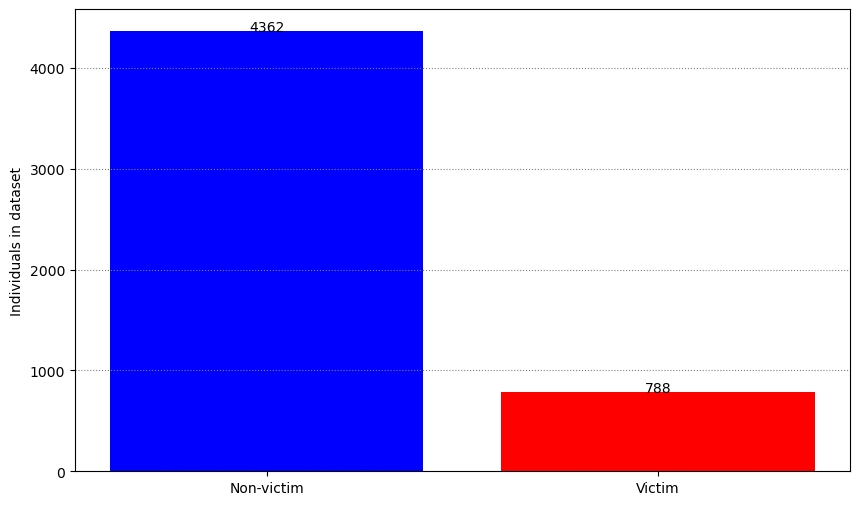

In [380]:
#create imbalance ratio chart for binary task
#add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

fig, ax = plt.subplots(figsize = (10,6))
ax.bar(x = ['Non-victim', 'Victim'], height = y.value_counts(), color = ['blue', 'red'])
addlabels(x = ['Non-victim', 'Victim'], y = y.value_counts())
plt.grid(True, which= 'both', axis='y', linestyle = ':', color='gray')
plt.ylabel('Individuals in dataset')
plt.show()


In [381]:
#save binary dataset
df = pd.concat([parameters, y], axis = 1)
df.to_csv('binary_task.csv', index=False)

In [382]:
df = pd.read_csv('binary_task.csv')
df.head()

geslacht  leeftijd  aantalki  oplcat  ac18f092  ac18f007  ac18f036  \
0         1        71         0       2         1         4         1   
1         0        64         0       2         1         3         1   
2         0        41         0       4         1         1         1   
3         1        64         0       4         1         4         7   
4         1        78         0       2         1         4         1   

   ac18f045  ac18f047  ac18f048  ...  cs17j262  cs17j263  cs17j431  cs17j432  \
0         1         5         5  ...         1         1         1         0   
1         1         4         5  ...         0         1         0         0   
2         2         4         3  ...         1         0         1         0   
3         1         5         5  ...         0         0         1         0   
4         1         4         2  ...         0         0         1         0   

   cs17j486  cs17j264  cs17j435  cs17j265  cs17j266  all  
0         1         0         0         0         0    0  
1         0         1         0         0         0    0  
2         0         1         1         0         1    0  
3         0         1         0         0         1    0  
4         0         0         0         0         0    0  

[5 rows x 49 columns]

In [383]:
#load binary dataset and onehotencode certain parameters
parameters = df.drop('all', axis=1)
y = df['all']

onehot_cols = ['ac18f092', 'ac18f007', 'ac18f045', 'ac18f066', 'ac18f067', 'ac18f069', 'ac18f070', 'ac18f071', 'ac18f080', 'ac18f081', 'ac18f082', 'ac18f083', 'ac18f084', 'ac18f085', 'ac18f087', 'ac18f088', 'ac18f089', 'ac18f090', 'ac18f091']

onehot = ce.OneHotEncoder(cols= onehot_cols)

parameters = onehot.fit_transform(parameters)
parameters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5150 entries, 0 to 5149
Columns: 104 entries, geslacht to cs17j266
dtypes: int64(104)
memory usage: 4.1 MB


In [384]:
#EDA average age and gender proportion

#female = 1
gender_prop = parameters['geslacht'].sum(axis = 0)/len(parameters)

#average age calc
average_age = parameters['leeftijd'].median(axis = 0)

print(gender_prop)
print(average_age)

0.536504854368932
54.0


In [385]:
X_train, X_test, y_train, y_test = train_test_split(parameters, y, test_size=0.2, stratify= y, random_state=random_state)
X_train.shape

(4120, 104)

In [23]:
#evaluation metrics

def evalution(actual, predict, probabilities) :
    print("Accuracy:", accuracy_score(actual, predict))
    print("Binary F1:", f1_score(actual, predict, average = 'binary', pos_label= 1))
    print("Weighted F1", f1_score(actual, predict, average = 'weighted', pos_label= 1))
    print("Recall", recall_score(actual, predict))

    #confusion matrix
    confusion = confusion_matrix(actual, predict)
    matrix = ConfusionMatrixDisplay(confusion_matrix = confusion, display_labels = ['Non-victim', 'Victim'])
    matrix.plot()
    plt.show()

    # ROC curve
    fpr, tpr, thresholds = roc_curve(actual, probabilities)

    # Calculate AUC (Area Under Curve)
    auc_score = roc_auc_score(actual, probabilities)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    

In [387]:
#Randomoversampling
ros = RandomOverSampler(random_state=42)

[I 2024-06-17 15:03:57,938] A new study created in memory with name: no-name-5b9414b1-480e-4ec8-8f86-51b5fa64ebe1
[I 2024-06-17 15:03:59,234] Trial 0 finished with value: 0.0 and parameters: {'solver': 'newton-cg', 'C': 3.4636939550910304e-05, 'max_iter': 600, 'warm_start': True}. Best is trial 0 with value: 0.0.
[I 2024-06-17 15:04:01,154] Trial 1 finished with value: 0.0 and parameters: {'solver': 'newton-cg', 'C': 3.656245833194415e-05, 'max_iter': 700, 'warm_start': False}. Best is trial 0 with value: 0.0.
c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

Best trial:
 Value: 0.07702105544339909
 Params: 
    solver: lbfgs
    C: 0.17706249335701757
    max_iter: 450
    warm_start: False


c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6456310679611651
Binary F1: 0.33515482695810567
Weighted F1 0.6935072851376792
Recall 0.5822784810126582


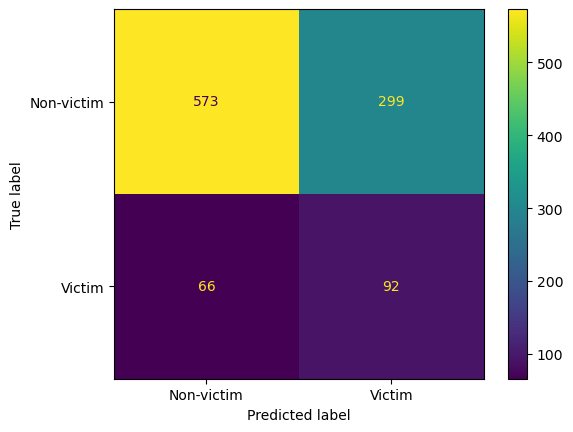

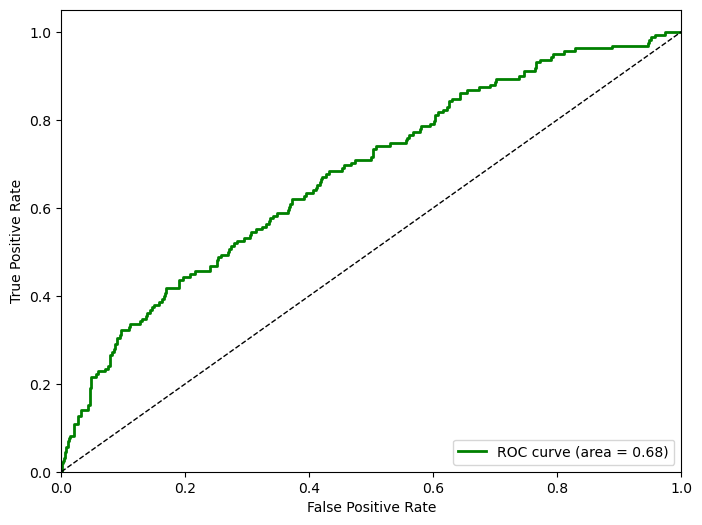

In [304]:
#simple logistic regression no oversamplin optuna
def objective(trial):
    # Suggest values for the hyperparameters
    solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cg'])
    C = trial.suggest_float('C', 1e-6, 1e2, log = True)
    max_iter = trial.suggest_int('max_iter', 100, 800, step = 50)
    warm_start = trial.suggest_categorical('warm_start', [True, False])

    # Create the classifier with suggested parameters
    classifier = LogisticRegression(solver=solver, C=C, max_iter=max_iter, warm_start=warm_start, random_state=random_state)
    
    # Create a pipeline
    pipeline = IMBPipeline([
        ('classifier', classifier)
    ])

    # Cross-validation within the trial
    skf = StratifiedKFold(n_splits=5)
    scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_valid_fold)
        score = f1_score(y_valid_fold, preds, average='binary')  # Ensure appropriate average method
        scores.append(score)

    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
best_classifier = LogisticRegression(**best_params, random_state=random_state)
best_pipeline = IMBPipeline([
    ('smote', ros),
    ('classifier', best_classifier)
])

best_pipeline.fit(X_train, y_train)

predictions = best_pipeline.predict(X_test)
probabilities = best_pipeline.predict_proba(X_test)[:, 1]

y_pred = predictions
evalution(y_test, y_pred, probabilities)

[I 2024-06-16 21:02:11,814] A new study created in memory with name: no-name-b111daf5-7ea3-4bdc-90fd-a25494918966


c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Best trial:
 Value: 0.3228349268054778
 Params: 
    solver: newton-cg
    C: 0.0022684405541404102
    max_iter: 150
    warm_start: True
Accuracy: 0.6514563106796116
Binary F1: 0.3623445825932504
Weighted F1 0.6991587801768269
Recall 0.6455696202531646


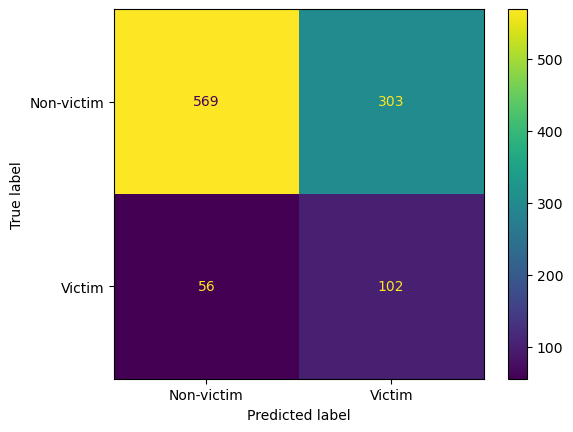

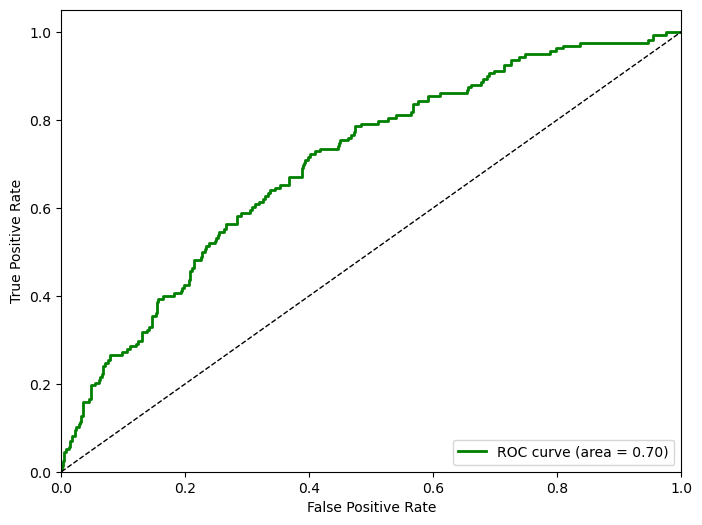

In [216]:
#optuna ros LR
def objective(trial):
    # Suggest values for the hyperparameters
    solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cg'])
    C = trial.suggest_float('C', 1e-6, 1e2, log = True)
    max_iter = trial.suggest_int('max_iter', 100, 800, step = 50)
    warm_start = trial.suggest_categorical('warm_start', [True, False])

    # Create the classifier with suggested parameters
    classifier = LogisticRegression(solver=solver, C=C, max_iter=max_iter, warm_start=warm_start, random_state=random_state)
    
    # Create a pipeline
    pipeline = IMBPipeline([
        ('smote', ros),
        ('classifier', classifier)
    ])

    # Cross-validation within the trial
    skf = StratifiedKFold(n_splits=5)
    scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_valid_fold)
        score = f1_score(y_valid_fold, preds, average='binary')  # Ensure appropriate average method
        scores.append(score)

    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
best_classifier = LogisticRegression(**best_params, random_state=random_state)
best_pipeline = IMBPipeline([
    ('smote', ros),
    ('classifier', best_classifier)
])

best_pipeline.fit(X_train, y_train)

predictions = best_pipeline.predict(X_test)
probabilities = best_pipeline.predict_proba(X_test)[:, 1]

y_pred = predictions
evalution(y_test, y_pred, probabilities)

[I 2024-06-17 15:05:47,856] A new study created in memory with name: no-name-b44fc3ea-2054-465e-810a-b75d8f0ce5aa
[I 2024-06-17 15:05:59,573] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 500, 'max_depth': 50, 'min_samples_split': 9, 'min_samples_leaf': 15, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 0 with value: 0.0.
[I 2024-06-17 15:06:04,911] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 250, 'max_depth': 50, 'min_samples_split': 10, 'min_samples_leaf': 17, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 0 with value: 0.0.
[I 2024-06-17 15:07:23,446] Trial 2 finished with value: 0.0460143667209174 and parameters: {'n_estimators': 550, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': None, 'criterion': 'gini'}. Best is trial 2 with value: 0.0460143667209174.
[I 2024-06-17 15:07:33,765] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 450, 'max_depth': 20, 'min_samp

Best trial:
 Value: 0.08786784811073255
 Params: 
    n_estimators: 250
    max_depth: 50
    min_samples_split: 10
    min_samples_leaf: 1
    max_features: None
    criterion: gini
Accuracy: 0.8504854368932039
Binary F1: 0.09411764705882353
Weighted F1 0.7920570256149925
Recall 0.05063291139240506


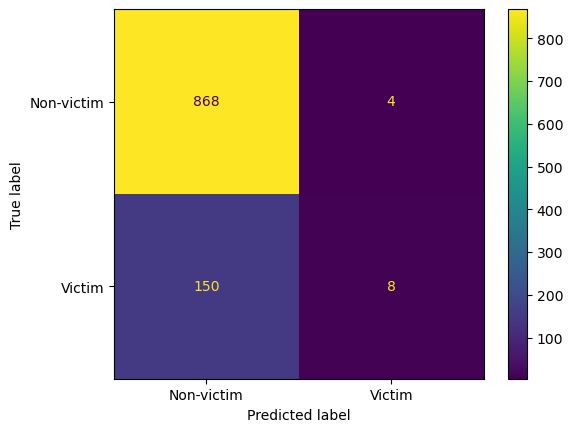

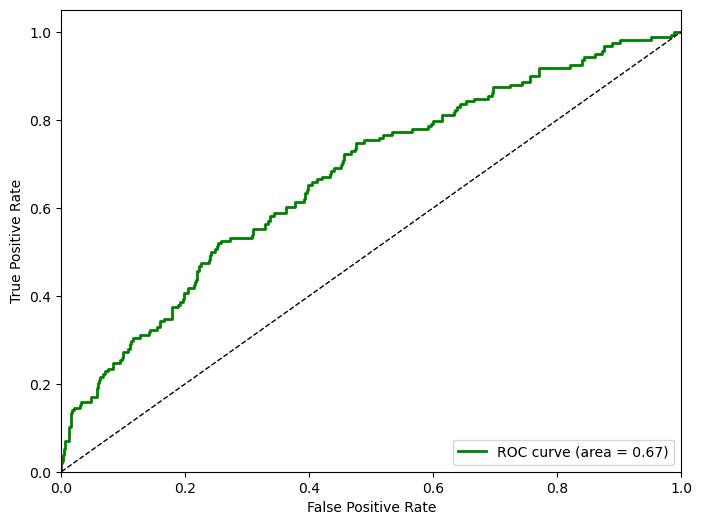

In [305]:
#optuna RF no oversampling
def objective(trial):

    # parameter grid
    n_estimators = trial.suggest_int('n_estimators', 100, 600, step=50)
    max_depth = trial.suggest_categorical('max_depth', [None, 10, 20, 30, 50, 60])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    # Setup the classifier
    classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        criterion=criterion,
        random_state=42
    )

    # Create a pipeline
    pipeline = IMBPipeline([
        ('classifier', classifier)
    ])

    # Cross-validation within the trial
    skf = StratifiedKFold(n_splits=5)
    scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_valid_fold)
        score = f1_score(y_valid_fold, preds, average='binary')  # Ensure appropriate average method
        scores.append(score)

    return np.mean(scores)

#pruner = MedianPruner()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
classifier = RandomForestClassifier(**best_params, random_state=random_state)
best_pipeline = IMBPipeline([
    ('classifier', classifier)
])

best_pipeline.fit(X_train, y_train)

predictions = best_pipeline.predict(X_test)
probabilities = best_pipeline.predict_proba(X_test)[:, 1]

y_pred = predictions
evalution(y_test, y_pred, probabilities)

[I 2024-06-16 21:03:47,537] A new study created in memory with name: no-name-81b98420-9581-489f-a82c-e3731f28e0b9
[I 2024-06-16 21:03:58,680] Trial 0 finished with value: 0.30012890542587456 and parameters: {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 20, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 0 with value: 0.30012890542587456.
[I 2024-06-16 21:04:13,267] Trial 1 finished with value: 0.24119899403550993 and parameters: {'n_estimators': 300, 'max_depth': 50, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 0 with value: 0.30012890542587456.
[I 2024-06-16 21:06:52,982] Trial 2 finished with value: 0.23470242312777048 and parameters: {'n_estimators': 550, 'max_depth': 60, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': None, 'criterion': 'gini'}. Best is trial 0 with value: 0.30012890542587456.
[I 2024-06-16 21:07:06,110] Trial 3 finished with value: 0.30

Best trial:
 Value: 0.31111172511955115
 Params: 
    n_estimators: 450
    max_depth: 10
    min_samples_split: 18
    min_samples_leaf: 19
    max_features: sqrt
    criterion: gini
Accuracy: 0.7446601941747573
Binary F1: 0.3506172839506173
Weighted F1 0.7658504171414935
Recall 0.44936708860759494


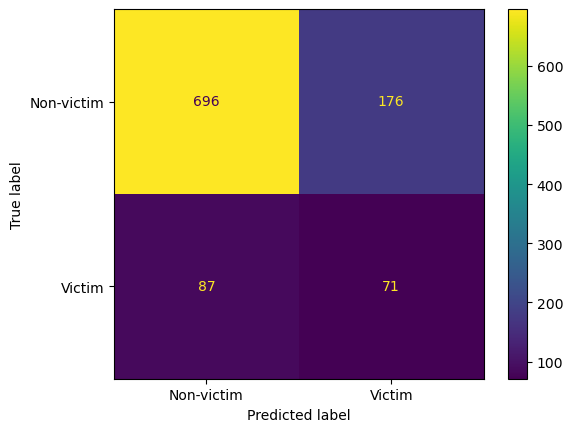

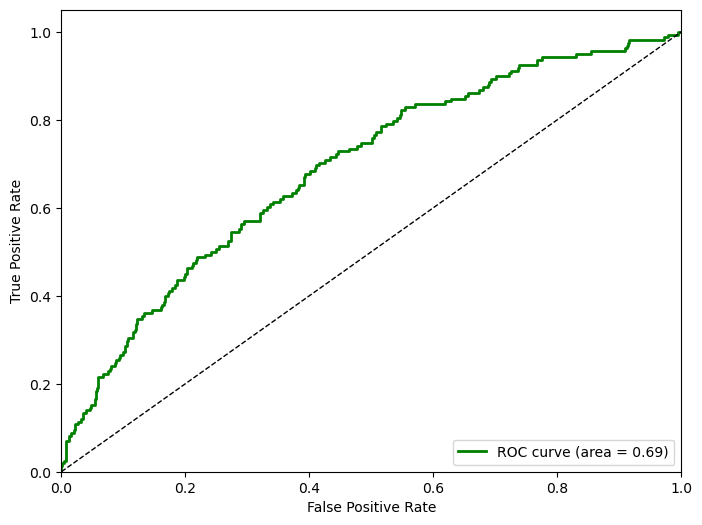

In [217]:
#optuna RF ros
def objective(trial):

    # parameter grid
    n_estimators = trial.suggest_int('n_estimators', 100, 600, step=50)
    max_depth = trial.suggest_categorical('max_depth', [None, 10, 20, 30, 50, 60])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    # Setup the classifier
    classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        criterion=criterion,
        random_state=42
    )

    # Create a pipeline
    pipeline = IMBPipeline([
        ('smote', ros),
        ('classifier', classifier)
    ])

    # Cross-validation within the trial
    skf = StratifiedKFold(n_splits=5)
    scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_valid_fold)
        score = f1_score(y_valid_fold, preds, average='binary')  # Ensure appropriate average method
        scores.append(score)

    return np.mean(scores)

#pruner = MedianPruner()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
classifier = RandomForestClassifier(**best_params, random_state=random_state)
best_pipeline = IMBPipeline([
    ('smote', ros),
    ('classifier', classifier)
])

best_pipeline.fit(X_train, y_train)

predictions = best_pipeline.predict(X_test)
probabilities = best_pipeline.predict_proba(X_test)[:, 1]

y_pred = predictions
evalution(y_test, y_pred, probabilities)

[I 2024-06-17 15:33:27,307] A new study created in memory with name: no-name-7d64596b-549e-4345-aa36-bac1e79f3178
[I 2024-06-17 15:33:34,197] Trial 0 finished with value: 0.056265959886898684 and parameters: {'kernel': 'rbf', 'C': 4.4994600375147, 'gamma': 'auto'}. Best is trial 0 with value: 0.056265959886898684.
[I 2024-06-17 15:33:38,954] Trial 1 finished with value: 0.0 and parameters: {'kernel': 'linear', 'C': 1.0149553403702574e-05, 'gamma': 'scale'}. Best is trial 0 with value: 0.056265959886898684.
[I 2024-06-17 15:33:48,881] Trial 2 finished with value: 0.0 and parameters: {'kernel': 'rbf', 'C': 3.7274917502519256, 'gamma': 'scale'}. Best is trial 0 with value: 0.056265959886898684.
[I 2024-06-17 15:38:38,703] Trial 3 finished with value: 0.08764294241721886 and parameters: {'kernel': 'poly', 'C': 0.5444164467969267, 'gamma': 'auto', 'coef0': 0.0}. Best is trial 3 with value: 0.08764294241721886.
[I 2024-06-17 15:38:41,135] Trial 4 finished with value: 0.0 and parameters: {'ke

Best trial:
 Value: 0.24209234515446018
 Params: 
    kernel: poly
    C: 45.186880993259074
    gamma: auto
    coef0: 0.5
Accuracy: 0.7417475728155339
Binary F1: 0.24858757062146894
Weighted F1 0.7527323794294697
Recall 0.27848101265822783


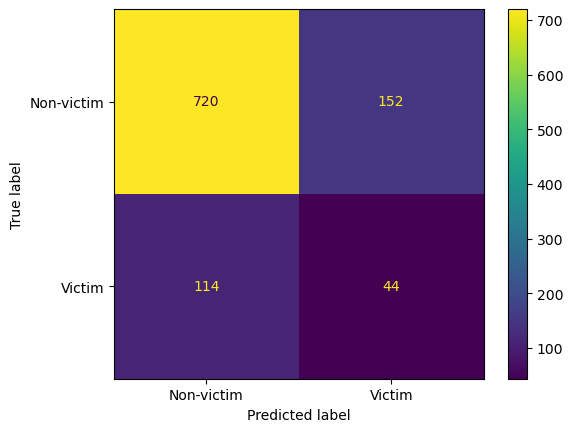

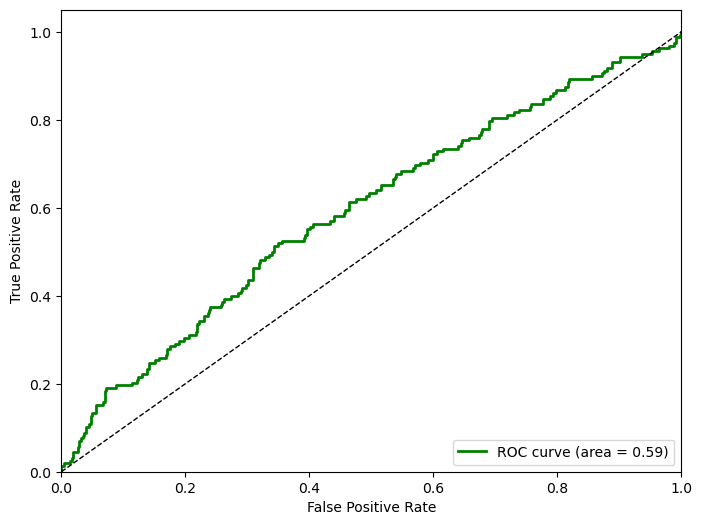

In [306]:
#optuna SVM no oversampling
def objective(trial):
    # Suggest values for the hyperparameters
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'sigmoid', 'poly'])
    C = trial.suggest_float('C', 1e-5, 1e2, log=True)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

    # Additional parameters for 'poly' and 'sigmoid'
    coef0 = trial.suggest_float('coef0', 0, 1, step=0.1) if kernel in ['sigmoid', 'poly'] else 0.0

    # Create the SVM classifier
    classifier = svm.SVC(kernel=kernel, C=C, gamma=gamma, coef0=coef0, random_state=random_state)

    # Create a pipeline
    pipeline = IMBPipeline([
        ('classifier', classifier)
    ])

    # Cross-validation within the trial
    skf = StratifiedKFold(n_splits=5)
    scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_valid_fold)
        score = f1_score(y_valid_fold, preds, average='binary')  # Ensure appropriate average method
        scores.append(score)

    return np.mean(scores)

#pruner = MedianPruner()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
classifier = svm.SVC(**best_params, probability=True, random_state=random_state)
best_pipeline = IMBPipeline([
    ('classifier', classifier)
])

best_pipeline.fit(X_train, y_train)

predictions = best_pipeline.predict(X_test)
probabilities = best_pipeline.predict_proba(X_test)[:, 1]

y_pred = predictions
evalution(y_test, y_pred, probabilities)

[I 2024-06-16 21:22:27,859] A new study created in memory with name: no-name-51d215f6-100f-48bd-9dc1-9f7d2c46cc4c
[I 2024-06-16 21:23:03,012] Trial 0 finished with value: 0.29617067470867986 and parameters: {'kernel': 'rbf', 'C': 0.0004827220571462104, 'gamma': 'scale'}. Best is trial 0 with value: 0.29617067470867986.
[I 2024-06-16 21:23:33,859] Trial 1 finished with value: 0.2954505214983104 and parameters: {'kernel': 'rbf', 'C': 0.002628529632355088, 'gamma': 'auto'}. Best is trial 0 with value: 0.29617067470867986.
[I 2024-06-16 21:24:52,752] Trial 2 finished with value: 0.30667459068063885 and parameters: {'kernel': 'linear', 'C': 0.6851111365563715, 'gamma': 'auto'}. Best is trial 2 with value: 0.30667459068063885.
[I 2024-06-16 21:25:13,296] Trial 3 finished with value: 0.3020155490820603 and parameters: {'kernel': 'rbf', 'C': 0.6972581924954195, 'gamma': 'scale'}. Best is trial 2 with value: 0.30667459068063885.
[I 2024-06-16 21:25:25,565] Trial 4 finished with value: 0.3137728

Best trial:
 Value: 0.31998911288698484
 Params: 
    kernel: linear
    C: 0.0103904748574018
    gamma: auto
Accuracy: 0.6427184466019418
Binary F1: 0.33574007220216606
Weighted F1 0.6912316292760099
Recall 0.5886075949367089


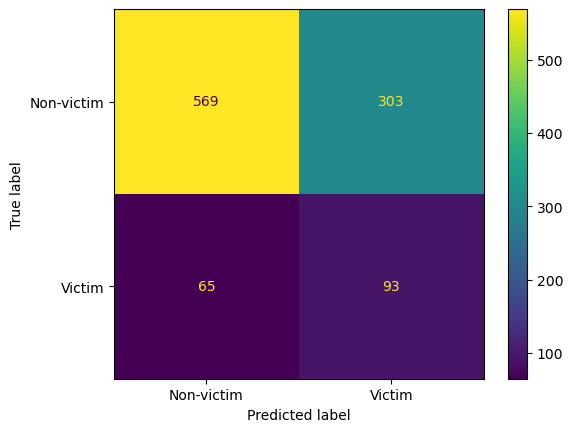

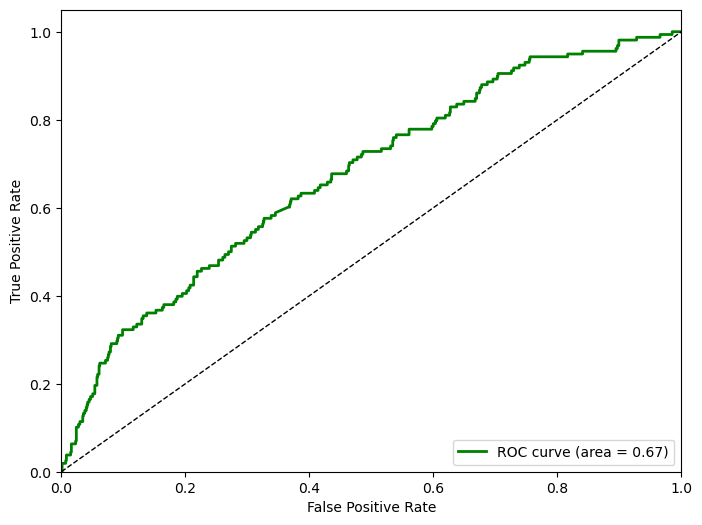

In [218]:
#optuna SVM ros
def objective(trial):
    # Suggest values for the hyperparameters
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'sigmoid', 'poly'])
    C = trial.suggest_float('C', 1e-5, 1e2, log=True)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

    # Additional parameters for 'poly' and 'sigmoid'
    coef0 = trial.suggest_float('coef0', 0, 1, step=0.1) if kernel in ['sigmoid', 'poly'] else 0.0

    # Create the SVM classifier
    classifier = svm.SVC(kernel=kernel, C=C, gamma=gamma, coef0=coef0, random_state=random_state)

    # Create a pipeline
    pipeline = IMBPipeline([
        ('smote', ros),
        ('classifier', classifier)
    ])

    # Cross-validation within the trial
    skf = StratifiedKFold(n_splits=5)
    scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_valid_fold)
        score = f1_score(y_valid_fold, preds, average='binary')  # Ensure appropriate average method
        scores.append(score)

    return np.mean(scores)

#pruner = MedianPruner()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
classifier = svm.SVC(**best_params, probability=True, random_state=random_state)
best_pipeline = IMBPipeline([
    ('smote', ros),
    ('classifier', classifier)
])

best_pipeline.fit(X_train, y_train)

predictions = best_pipeline.predict(X_test)
probabilities = best_pipeline.predict_proba(X_test)[:, 1]

y_pred = predictions
evalution(y_test, y_pred, probabilities)

[I 2024-06-18 03:13:56,092] A new study created in memory with name: no-name-d92dc1bd-8ec7-4238-a825-34e73aa5e619
[I 2024-06-18 03:13:57,754] Trial 0 finished with value: 0.06283334915613588 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 50, 'p': 1}. Best is trial 0 with value: 0.06283334915613588.
[I 2024-06-18 03:13:59,679] Trial 1 finished with value: 0.04119334209693533 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 20, 'p': 1}. Best is trial 0 with value: 0.06283334915613588.
[I 2024-06-18 03:14:00,736] Trial 2 finished with value: 0.00622577519379845 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 50, 'p': 2}. Best is trial 0 with value: 0.06283334915613588.
[I 2024-06-18 03:14:01,871] Trial 3 finished with value: 0.023796777655771827 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'algorithm': 'ball_tree', 'leaf_size': 20, 'p': 2}

Best trial:
 Value: 0.16642611012902112
 Params: 
    n_neighbors: 2
    weights: distance
    algorithm: brute
    leaf_size: 35
    p: 2
Accuracy: 0.7689320388349514
Binary F1: 0.13768115942028986
Weighted F1 0.7547784316731877
Recall 0.12025316455696203


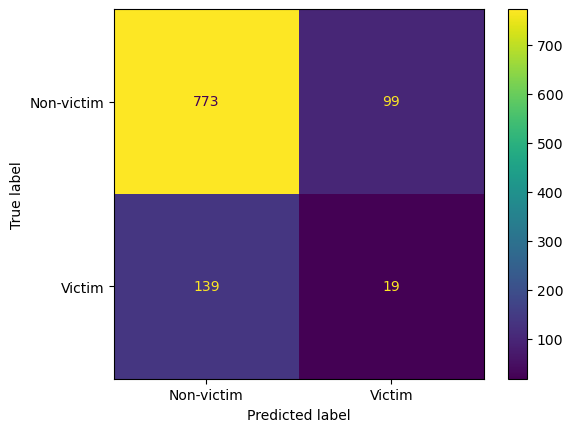

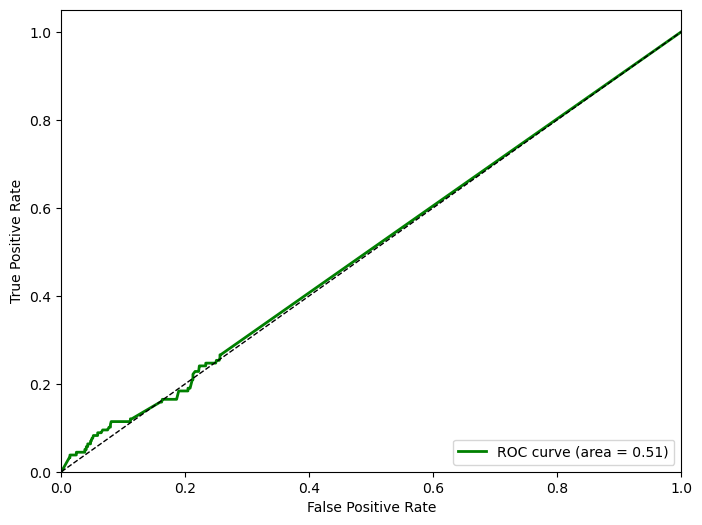

In [307]:
#knn optuna no oversampling
def objective(trial):

    # parameter grid
    n_neighbors = trial.suggest_int('n_neighbors', 2, 10)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    leaf_size = trial.suggest_int('leaf_size', 20, 60, step=5)
    p = trial.suggest_categorical('p', [1, 2])

    # Set up the classifier
    classifier = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        algorithm=algorithm,
        leaf_size=leaf_size,
        p=p
    )

    # Create a pipeline
    pipeline = IMBPipeline([
        ('classifier', classifier)
    ])

    # Cross-validation within the trial
    skf = StratifiedKFold(n_splits=5)
    scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_valid_fold)
        score = f1_score(y_valid_fold, preds, average='binary')  # Ensure appropriate average method
        scores.append(score)

    return np.mean(scores)

#pruner = MedianPruner()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
classifier = KNeighborsClassifier(**best_params)
best_pipeline = IMBPipeline([
    ('classifier', classifier)
])

best_pipeline.fit(X_train, y_train)

predictions = best_pipeline.predict(X_test)
probabilities = best_pipeline.predict_proba(X_test)[:, 1]

y_pred = predictions
evalution(y_test, y_pred, probabilities)

[I 2024-06-17 00:41:18,078] A new study created in memory with name: no-name-4e177786-3d76-4f06-b4f4-9b6d403f4d69
[I 2024-06-17 00:41:22,725] Trial 0 finished with value: 0.21684248823913516 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'algorithm': 'kd_tree', 'leaf_size': 30, 'p': 1}. Best is trial 0 with value: 0.21684248823913516.
[I 2024-06-17 00:41:27,036] Trial 1 finished with value: 0.21693722906806379 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 50, 'p': 1}. Best is trial 1 with value: 0.21693722906806379.
[I 2024-06-17 00:41:28,118] Trial 2 finished with value: 0.2705981472962213 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'brute', 'leaf_size': 55, 'p': 2}. Best is trial 2 with value: 0.2705981472962213.
[I 2024-06-17 00:41:31,095] Trial 3 finished with value: 0.2517700193477573 and parameters: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 40, 'p': 2}. Best 

Best trial:
 Value: 0.2759721130990836
 Params: 
    n_neighbors: 9
    weights: distance
    algorithm: brute
    leaf_size: 55
    p: 2
Accuracy: 0.6009708737864078
Binary F1: 0.2594594594594595
Weighted F1 0.6552042478888267
Recall 0.45569620253164556


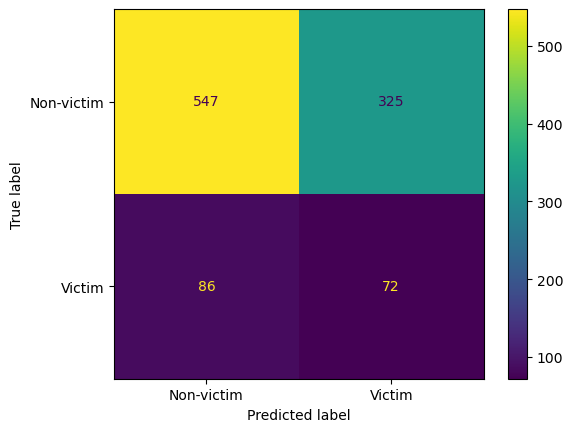

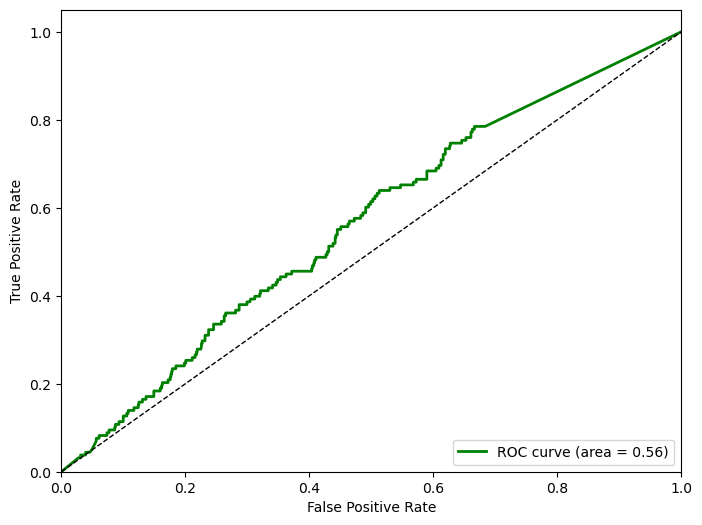

In [219]:
#knn ros optuna
def objective(trial):

    # parameter grid
    n_neighbors = trial.suggest_int('n_neighbors', 2, 10)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    leaf_size = trial.suggest_int('leaf_size', 20, 60, step=5)
    p = trial.suggest_categorical('p', [1, 2])

    # Set up the classifier
    classifier = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        algorithm=algorithm,
        leaf_size=leaf_size,
        p=p
    )

    # Create a pipeline
    pipeline = IMBPipeline([
        ('smote', ros),
        ('classifier', classifier)
    ])

    # Cross-validation within the trial
    skf = StratifiedKFold(n_splits=5)
    scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_valid_fold)
        score = f1_score(y_valid_fold, preds, average='binary')  # Ensure appropriate average method
        scores.append(score)

    return np.mean(scores)

#pruner = MedianPruner()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
classifier = KNeighborsClassifier(**best_params)
best_pipeline = IMBPipeline([
    ('smote', ros),
    ('classifier', classifier)
])

best_pipeline.fit(X_train, y_train)

predictions = best_pipeline.predict(X_test)
probabilities = best_pipeline.predict_proba(X_test)[:, 1]

y_pred = predictions
evalution(y_test, y_pred, probabilities)

## Use of smote

In [66]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4175 entries, 414 to 2643
Columns: 113 entries, geslacht to cs17j266
dtypes: int64(113)
memory usage: 3.6 MB


In [220]:
#smote plus one hot encoder application

smote = SMOTENC(categorical_features = X_train.drop(['ac18f036', 'leeftijd', 'aantalki'], axis=1).columns.tolist(), random_state=42, sampling_strategy='auto')

X_smote, y_smote = smote.fit_resample(X_train, y_train)

print(X_smote.tail(20))

      geslacht  leeftijd  aantalki  oplcat  ac18f092_1  ac18f092_2  \
6960         0        32         0       4           1           0   
6961         0        35         0       2           1           0   
6962         0        33         0       6           1           0   
6963         0        66         0       5           1           0   
6964         0        76         0       5           1           0   
6965         0        26         0       4           1           0   
6966         0        24         2       5           0           0   
6967         0        48         0       5           1           0   
6968         0        49         0       4           1           0   
6969         1        31         1       5           0           1   
6970         1        49         2       5           1           0   
6971         0        62         0       5           1           0   
6972         0        55         1       6           1           0   
6973         0      

[I 2024-06-17 00:43:20,096] A new study created in memory with name: no-name-d2d84c62-fef4-4b50-93e6-78aff5e16715
[I 2024-06-17 00:43:55,681] Trial 0 finished with value: 0.20518161509597999 and parameters: {'solver': 'newton-cg', 'C': 12.605065607787965, 'max_iter': 350, 'warm_start': False}. Best is trial 0 with value: 0.20518161509597999.
[I 2024-06-17 00:44:24,439] Trial 1 finished with value: 0.2963975103237776 and parameters: {'solver': 'newton-cg', 'C': 9.421505736974951e-06, 'max_iter': 150, 'warm_start': False}. Best is trial 1 with value: 0.2963975103237776.
[I 2024-06-17 00:44:55,288] Trial 2 finished with value: 0.24780912684211037 and parameters: {'solver': 'lbfgs', 'C': 0.008534831927834977, 'max_iter': 650, 'warm_start': False}. Best is trial 1 with value: 0.2963975103237776.
[I 2024-06-17 00:45:24,245] Trial 3 finished with value: 0.2977504094925659 and parameters: {'solver': 'newton-cg', 'C': 1.1101347186919746e-06, 'max_iter': 400, 'warm_start': False}. Best is trial 

Best trial:
 Value: 0.3004554427827606
 Params: 
    solver: newton-cg
    C: 5.506201444920276e-06
    max_iter: 700
    warm_start: True
Accuracy: 0.5864077669902913
Binary F1: 0.30618892508143325
Weighted F1 0.6441568782550491
Recall 0.5949367088607594


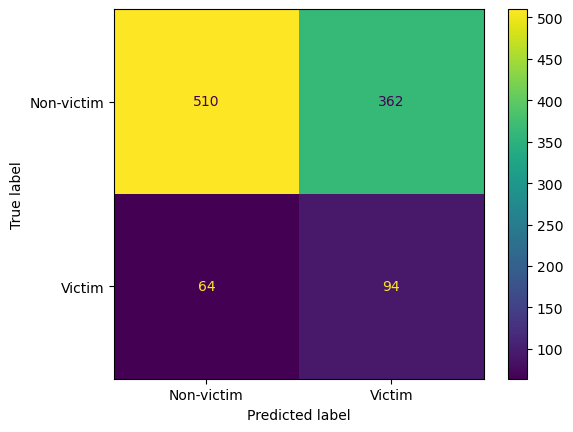

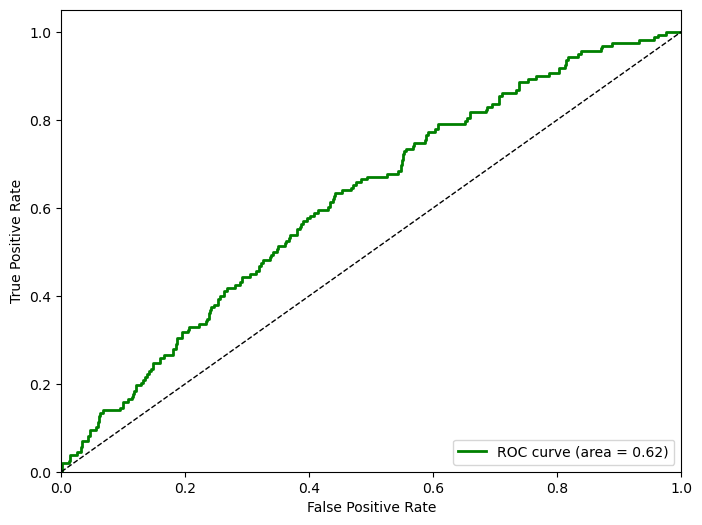

In [221]:
#LR with smote and optuna

def objective(trial):
    # Suggest values for the hyperparameters
    solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cg'])
    C = trial.suggest_float('C', 1e-6, 1e2, log = True)
    max_iter = trial.suggest_int('max_iter', 100, 800, step = 50)
    warm_start = trial.suggest_categorical('warm_start', [True, False])

    # Create the classifier with suggested parameters
    classifier = LogisticRegression(solver=solver, C=C, max_iter=max_iter, warm_start=warm_start, random_state=random_state)
    
    # Create a pipeline
    pipeline = IMBPipeline([
        ('smote', smote),
        ('classifier', classifier)
    ])

    # Cross-validation within the trial
    skf = StratifiedKFold(n_splits=5)
    scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_valid_fold)
        score = f1_score(y_valid_fold, preds, average='binary')  # Ensure appropriate average method
        scores.append(score)

    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
best_classifier = LogisticRegression(**best_params, random_state=random_state)
best_pipeline = IMBPipeline([
    ('smote', smote),
    ('classifier', best_classifier)
])

best_pipeline.fit(X_train, y_train)

predictions = best_pipeline.predict(X_test)
probabilities = best_pipeline.predict_proba(X_test)[:, 1]

y_pred = predictions
evalution(y_test, y_pred, probabilities)

[I 2024-06-17 01:08:12,616] A new study created in memory with name: no-name-81744058-1644-4b78-b9fe-25d8e06ebf42


[I 2024-06-17 01:08:55,634] Trial 0 finished with value: 0.2007565995043196 and parameters: {'n_estimators': 500, 'max_depth': None, 'min_samples_split': 7, 'min_samples_leaf': 18, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 0 with value: 0.2007565995043196.
[I 2024-06-17 01:09:32,113] Trial 1 finished with value: 0.1865930464615156 and parameters: {'n_estimators': 250, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 12, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 0 with value: 0.2007565995043196.
[I 2024-06-17 01:10:27,878] Trial 2 finished with value: 0.15194645821144687 and parameters: {'n_estimators': 100, 'max_depth': 60, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': None, 'criterion': 'entropy'}. Best is trial 0 with value: 0.2007565995043196.
[I 2024-06-17 01:11:11,341] Trial 3 finished with value: 0.1701598592119699 and parameters: {'n_estimators': 450, 'max_depth': 60, 'min_samples_split': 2, 'min_samples_leaf'

Best trial:
 Value: 0.21927992510128486
 Params: 
    n_estimators: 150
    max_depth: 10
    min_samples_split: 14
    min_samples_leaf: 6
    max_features: None
    criterion: entropy
Accuracy: 0.6786407766990291
Binary F1: 0.20240963855421687
Weighted F1 0.7073014956512094
Recall 0.26582278481012656


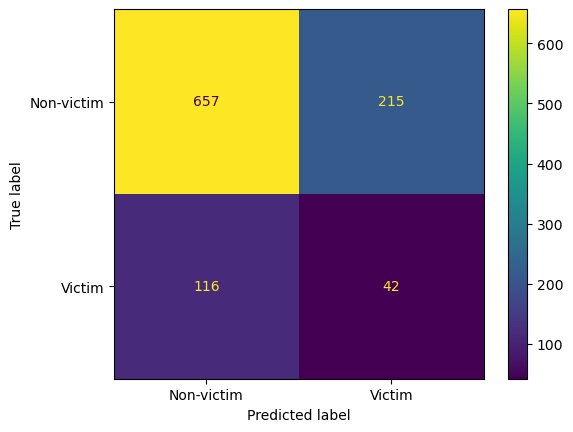

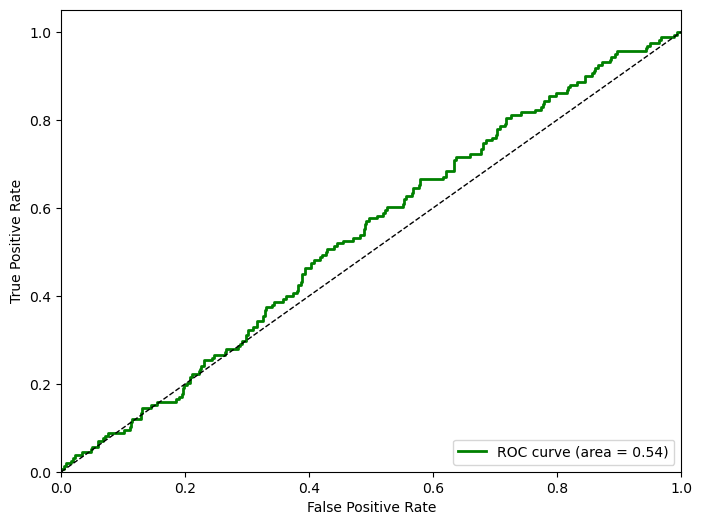

In [222]:
#RF  with optuna and smote
def objective(trial):

    # parameter grid
    n_estimators = trial.suggest_int('n_estimators', 100, 600, step=50)
    max_depth = trial.suggest_categorical('max_depth', [None, 10, 20, 30, 50, 60])
    min_samples_split = trial.suggest_categorical('min_samples_split', [2, 5, 7, 10, 12, 14, 16])
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [1, 2, 4, 6, 8, 10, 12, 14, 16, 18])
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    # Setup the classifier
    classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        criterion=criterion,
        random_state=42
    )

    # Create a pipeline
    pipeline = IMBPipeline([
        ('smote', smote),
        ('classifier', classifier)
    ])

    # Cross-validation within the trial
    skf = StratifiedKFold(n_splits=5)
    scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_valid_fold)
        score = f1_score(y_valid_fold, preds, average='binary')  # Ensure appropriate average method
        scores.append(score)

    return np.mean(scores)

#pruner = MedianPruner()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
classifier = RandomForestClassifier(**best_params, random_state=random_state)
best_pipeline = IMBPipeline([
    ('smote', smote),
    ('classifier', classifier)
])

best_pipeline.fit(X_train, y_train)

predictions = best_pipeline.predict(X_test)
probabilities = best_pipeline.predict_proba(X_test)[:, 1]

y_pred = predictions
evalution(y_test, y_pred, probabilities)

[I 2024-06-17 02:00:45,433] A new study created in memory with name: no-name-40cd1f79-e7f3-4cbd-a09e-4079e5ee4ce9
[I 2024-06-17 02:01:48,874] Trial 0 finished with value: 0.17298336762553485 and parameters: {'kernel': 'sigmoid', 'C': 0.04903461656968779, 'gamma': 'scale', 'coef0': 0.8}. Best is trial 0 with value: 0.17298336762553485.
[I 2024-06-17 02:02:47,437] Trial 1 finished with value: 0.26293055585912617 and parameters: {'kernel': 'sigmoid', 'C': 0.5970146728752995, 'gamma': 'auto', 'coef0': 0.9}. Best is trial 1 with value: 0.26293055585912617.
[I 2024-06-17 02:16:58,113] Trial 2 finished with value: 0.1926811966269044 and parameters: {'kernel': 'linear', 'C': 30.984200001629368, 'gamma': 'scale'}. Best is trial 1 with value: 0.26293055585912617.
[I 2024-06-17 02:17:57,323] Trial 3 finished with value: 0.26293055585912617 and parameters: {'kernel': 'sigmoid', 'C': 8.837794463347338e-05, 'gamma': 'auto', 'coef0': 0.1}. Best is trial 1 with value: 0.26293055585912617.
[I 2024-06-1

Best trial:
 Value: 0.30057676411127765
 Params: 
    kernel: poly
    C: 0.018211574172512898
    gamma: scale
    coef0: 1.0
Accuracy: 0.5679611650485437
Binary F1: 0.30577223088923555
Weighted F1 0.6280114847115283
Recall 0.620253164556962


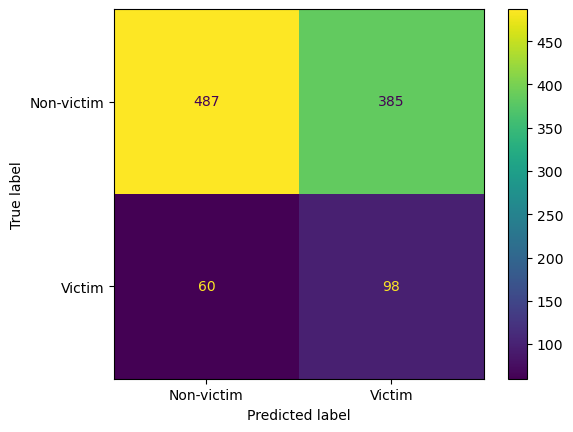

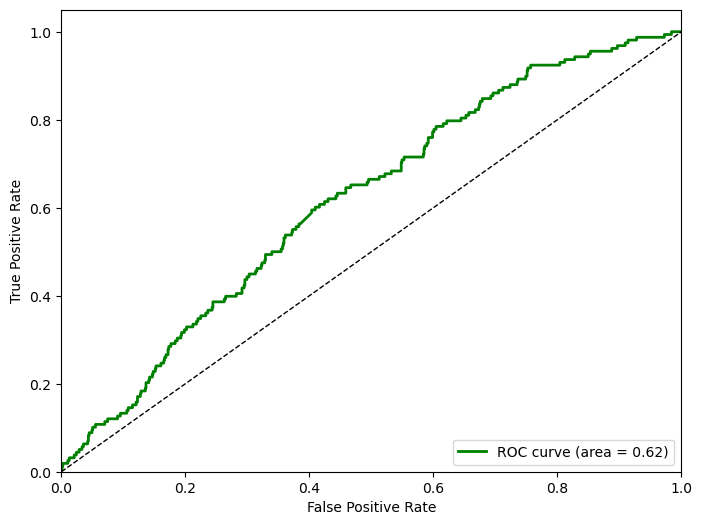

In [223]:
#optuna optimalisation voor svm
import optuna
from optuna.pruners import MedianPruner

def objective(trial):
    # Suggest values for the hyperparameters
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'sigmoid', 'poly'])
    C = trial.suggest_float('C', 1e-6, 1e2, log=True)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

    # Additional parameters for 'poly' and 'sigmoid'
    coef0 = trial.suggest_float('coef0', 0, 1, step = 0.1) if kernel in ['sigmoid', 'poly'] else 0.0

    # Create the SVM classifier
    classifier = svm.SVC(kernel=kernel, C=C, gamma=gamma, coef0=coef0, random_state=random_state)

    # Create a pipeline
    pipeline = IMBPipeline([
        ('smote', smote),
        ('classifier', classifier)
    ])

    # Cross-validation within the trial
    skf = StratifiedKFold(n_splits=5)
    scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_valid_fold)
        score = f1_score(y_valid_fold, preds, average='binary')  # Ensure appropriate average method
        scores.append(score)

    return np.mean(scores)

#pruner = MedianPruner()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
classifier = svm.SVC(**best_params, probability=True, random_state=random_state)
best_pipeline = IMBPipeline([
    ('smote', smote),
    ('classifier', classifier)
])

best_pipeline.fit(X_train, y_train)

predictions = best_pipeline.predict(X_test)
probabilities = best_pipeline.predict_proba(X_test)[:, 1]

y_pred = predictions
evalution(y_test, y_pred, probabilities)

[I 2024-06-17 03:02:37,485] A new study created in memory with name: no-name-ecf1662d-2847-46d1-bd8b-a91081ac3f6a
[I 2024-06-17 03:03:14,667] Trial 0 finished with value: 0.2576519338814717 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'ball_tree', 'leaf_size': 55, 'p': 1}. Best is trial 0 with value: 0.2576519338814717.
[I 2024-06-17 03:03:47,722] Trial 1 finished with value: 0.24846021670056642 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'brute', 'leaf_size': 60, 'p': 2}. Best is trial 0 with value: 0.2576519338814717.
[I 2024-06-17 03:04:24,393] Trial 2 finished with value: 0.26573833515584155 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree', 'leaf_size': 30, 'p': 1}. Best is trial 2 with value: 0.26573833515584155.
[I 2024-06-17 03:04:57,125] Trial 3 finished with value: 0.2674795553072055 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree', 'leaf_size': 20, 'p': 2}.

Best trial:
 Value: 0.2694848534989255
 Params: 
    n_neighbors: 9
    weights: uniform
    algorithm: auto
    leaf_size: 20
    p: 2
Accuracy: 0.4980582524271845
Binary F1: 0.2868965517241379
Weighted F1 0.5627512378860204
Recall 0.6582278481012658


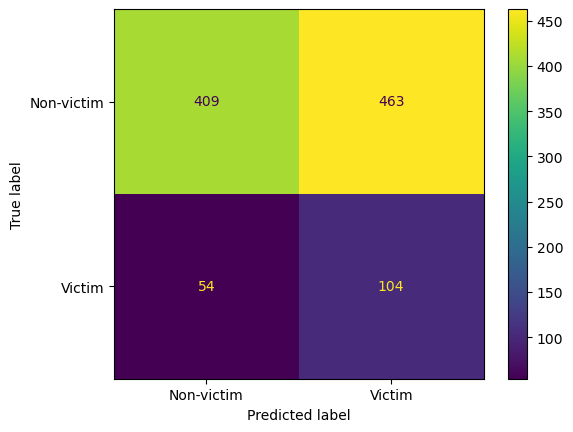

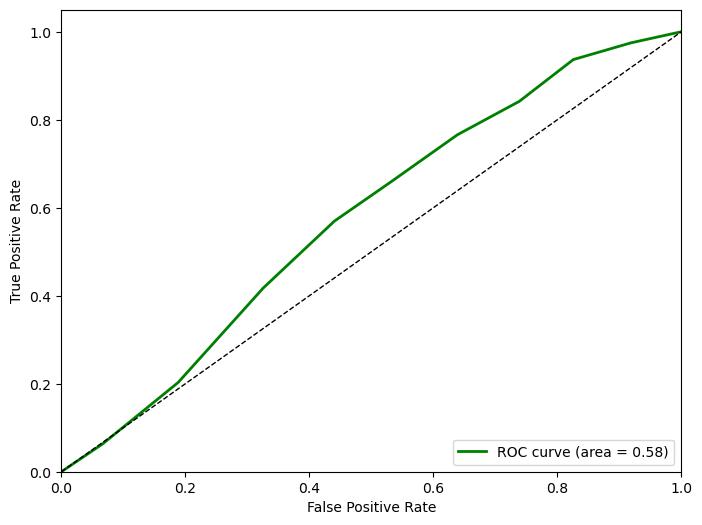

In [224]:
#optuna for knn with smote
def objective(trial):

    # parameter grid
    n_neighbors = trial.suggest_int('n_neighbors', 2, 10)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    leaf_size = trial.suggest_int('leaf_size', 20, 60, step=5)
    p = trial.suggest_categorical('p', [1, 2])

    # Set up the classifier
    classifier = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        algorithm=algorithm,
        leaf_size=leaf_size,
        p=p
    )

    # Create a pipeline
    pipeline = IMBPipeline([
        ('smote', smote),
        ('classifier', classifier)
    ])

    # Cross-validation within the trial
    skf = StratifiedKFold(n_splits=5)
    scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_valid_fold)
        score = f1_score(y_valid_fold, preds, average='binary')  # Ensure appropriate average method
        scores.append(score)

    return np.mean(scores)

#pruner = MedianPruner()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
classifier = KNeighborsClassifier(**best_params)
best_pipeline = IMBPipeline([
    ('smote', smote),
    ('classifier', classifier)
])

best_pipeline.fit(X_train, y_train)

predictions = best_pipeline.predict(X_test)
probabilities = best_pipeline.predict_proba(X_test)[:, 1]

y_pred = predictions
evalution(y_test, y_pred, probabilities)

# G-SMOTENC

In [391]:
#initialising G-SMOTENC
from mlresearch.synthetic_data import GeometricSMOTE

categorical_feature_names = X_train.drop(['ac18f036', 'leeftijd', 'aantalki'], axis=1).columns.tolist()
categorical_feature_indices = [X_train.columns.get_loc(col) for col in categorical_feature_names]

# Initialize GeometricSMOTE with categorical feature indices
gsmotenc = GeometricSMOTE(categorical_features=categorical_feature_indices, random_state=42, sampling_strategy='auto', truncation_factor=0.1, deformation_factor=0.2, n_jobs= 2)
#gsmotenc = GeometricSMOTE(categorical_features=categorical_feature_indices, random_state=42, sampling_strategy='auto', n_jobs= 2)

X_gsmote, y_gsmote = gsmotenc.fit_resample(X_train, y_train)

print(X_gsmote.tail(20))

      geslacht  leeftijd  aantalki  oplcat  ac18f092_1  ac18f092_2  \
6960         1        31         0       4           1           0   
6961         0        37         0       2           1           0   
6962         0        33         0       6           1           0   
6963         0        65         0       5           1           0   
6964         0        76         0       5           1           0   
6965         0        27         0       4           1           0   
6966         0        24         3       5           0           0   
6967         0        48         0       5           1           0   
6968         0        49         0       5           1           0   
6969         1        32         1       6           0           1   
6970         0        49         2       5           1           0   
6971         0        61         0       5           1           0   
6972         0        54         2       6           1           0   
6973         0      

In [392]:
X_gsmote['ac18f036'].unique()

array([ 3,  1,  8,  2,  6, 10,  4,  5, 11,  7, 12,  9,  0, 13, 15, 14, 22],
      dtype=int64)

[I 2024-06-18 13:41:16,779] A new study created in memory with name: no-name-a6e62747-b17e-4406-994c-58d0399643dc
[I 2024-06-18 13:43:18,383] Trial 0 finished with value: 0.2979104332580514 and parameters: {'solver': 'newton-cg', 'C': 4.793132795604054e-06, 'max_iter': 600, 'warm_start': False}. Best is trial 0 with value: 0.2979104332580514.
[I 2024-06-18 13:45:24,488] Trial 1 finished with value: 0.22752911679028665 and parameters: {'solver': 'newton-cg', 'C': 0.5013818625474192, 'max_iter': 250, 'warm_start': False}. Best is trial 0 with value: 0.2979104332580514.
c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

Best trial:
 Value: 0.29934609833030773
 Params: 
    solver: newton-cg
    C: 3.996680552903331e-06
    max_iter: 800
    warm_start: True
Accuracy: 0.583495145631068
Binary F1: 0.3024390243902439
Weighted F1 0.6416513949397229
Recall 0.5886075949367089


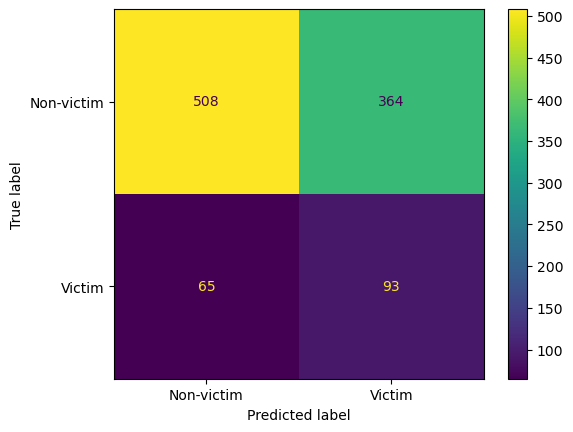

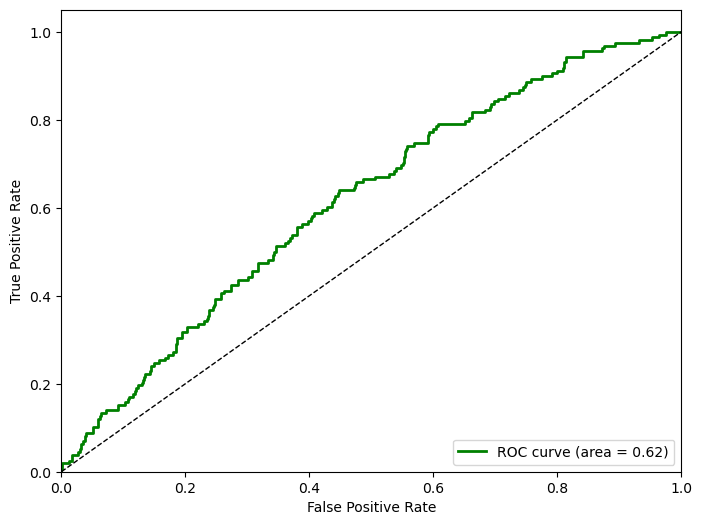

In [393]:
#LR with gsmote and optuna

def objective(trial):
    # Suggest values for the hyperparameters
    solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cg'])
    C = trial.suggest_float('C', 1e-7, 1e2, log = True)
    max_iter = trial.suggest_int('max_iter', 100, 800, step = 50)
    warm_start = trial.suggest_categorical('warm_start', [True, False])

    # Create the classifier with suggested parameters
    classifier = LogisticRegression(solver=solver, C=C, max_iter=max_iter, warm_start=warm_start, random_state=random_state)
    
    # Create a pipeline
    pipeline = IMBPipeline([
        ('gsmotenc', gsmotenc),
        ('classifier', classifier)
    ])

    # Cross-validation within the trial
    skf = StratifiedKFold(n_splits=5)
    scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_valid_fold)
        score = f1_score(y_valid_fold, preds, average='binary')  # Ensure appropriate average method
        scores.append(score)

    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
best_classifier = LogisticRegression(**best_params, random_state=random_state)
best_pipeline = IMBPipeline([
    ('gsmotenc', gsmotenc),
    ('classifier', best_classifier)
])

best_pipeline.fit(X_train, y_train)

predictions = best_pipeline.predict(X_test)
probabilities = best_pipeline.predict_proba(X_test)[:, 1]

y_pred = predictions
evalution(y_test, y_pred, probabilities)

[I 2024-06-17 05:47:06,842] A new study created in memory with name: no-name-6603785a-ee4d-44da-bfd1-7b5ca614ade1
[I 2024-06-17 05:50:15,298] Trial 0 finished with value: 0.20139180396687797 and parameters: {'n_estimators': 500, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 18, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 0 with value: 0.20139180396687797.
[I 2024-06-17 05:54:20,884] Trial 1 finished with value: 0.19373848204134858 and parameters: {'n_estimators': 300, 'max_depth': 60, 'min_samples_split': 14, 'min_samples_leaf': 16, 'max_features': None, 'criterion': 'entropy'}. Best is trial 0 with value: 0.20139180396687797.
[I 2024-06-17 05:57:24,142] Trial 2 finished with value: 0.17498190088332827 and parameters: {'n_estimators': 450, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 0 with value: 0.20139180396687797.
[I 2024-06-17 06:00:35,066] Trial 3 finished with value:

Best trial:
 Value: 0.2249151098720587
 Params: 
    n_estimators: 450
    max_depth: 10
    min_samples_split: 14
    min_samples_leaf: 18
    max_features: None
    criterion: gini
Accuracy: 0.6446601941747573
Binary F1: 0.21794871794871795
Weighted F1 0.6854014908998566
Recall 0.3227848101265823


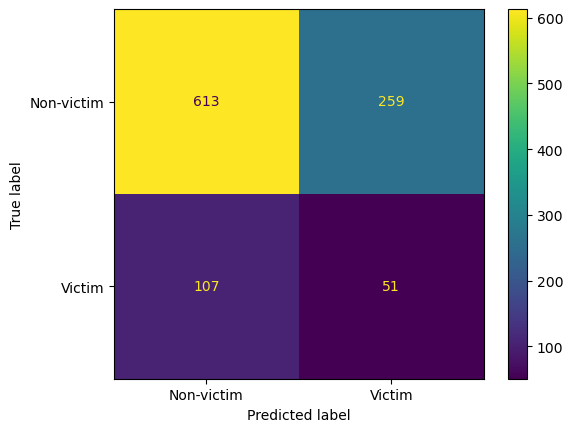

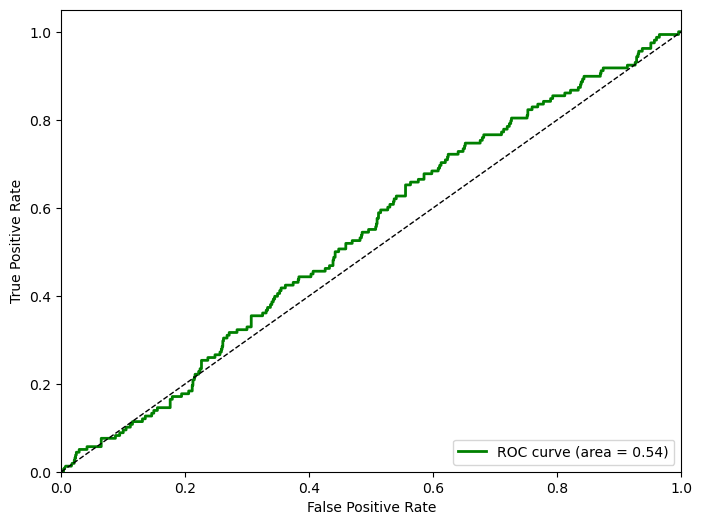

In [227]:
#RF  with optuna and gssmote
def objective(trial):

    # parameter grid
    n_estimators = trial.suggest_int('n_estimators', 100, 600, step=50)
    max_depth = trial.suggest_categorical('max_depth', [None, 10, 20, 30, 50, 60])
    min_samples_split = trial.suggest_categorical('min_samples_split', [2, 5, 7, 10, 12, 14, 16])
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [1, 2, 4, 6, 8, 10, 12, 14, 16, 18])
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    # Setup the classifier
    classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        criterion=criterion,
        random_state=42
    )

    # Create a pipeline
    pipeline = IMBPipeline([
        ('gsmotenc', gsmotenc),
        ('classifier', classifier)
    ])

    # Cross-validation within the trial
    skf = StratifiedKFold(n_splits=5)
    scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_valid_fold)
        score = f1_score(y_valid_fold, preds, average='binary')  # Ensure appropriate average method
        scores.append(score)

    return np.mean(scores)

#pruner = MedianPruner()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
classifier = RandomForestClassifier(**best_params, random_state=random_state)
best_pipeline = IMBPipeline([
    ('gsmotenc', gsmotenc),
    ('classifier', classifier)
])

best_pipeline.fit(X_train, y_train)

predictions = best_pipeline.predict(X_test)
probabilities = best_pipeline.predict_proba(X_test)[:, 1]

y_pred = predictions
evalution(y_test, y_pred, probabilities)

[I 2024-06-17 09:03:46,398] A new study created in memory with name: no-name-a68d263b-06c4-46e5-a392-3f4eda62da20
[I 2024-06-17 09:06:28,184] Trial 0 finished with value: 0.28282694809350695 and parameters: {'kernel': 'poly', 'C': 0.00029613216808579523, 'gamma': 'auto', 'coef0': 0.30000000000000004}. Best is trial 0 with value: 0.28282694809350695.
[I 2024-06-17 09:17:52,561] Trial 1 finished with value: 0.2279340989002953 and parameters: {'kernel': 'poly', 'C': 0.8447794092884763, 'gamma': 'auto', 'coef0': 0.5}. Best is trial 0 with value: 0.28282694809350695.
[I 2024-06-17 09:23:17,038] Trial 2 finished with value: 0.28278745832684016 and parameters: {'kernel': 'sigmoid', 'C': 0.2714438869845211, 'gamma': 'scale', 'coef0': 0.8}. Best is trial 0 with value: 0.28282694809350695.
[I 2024-06-17 09:28:36,719] Trial 3 finished with value: 0.29399178805768345 and parameters: {'kernel': 'rbf', 'C': 8.149086228036729e-06, 'gamma': 'scale'}. Best is trial 3 with value: 0.29399178805768345.
[I

Best trial:
 Value: 0.2972216823292019
 Params: 
    kernel: linear
    C: 4.5141861921455506e-06
    gamma: scale
Accuracy: 0.6067961165048543
Binary F1: 0.3053173241852487
Weighted F1 0.6612949909458392
Recall 0.5632911392405063


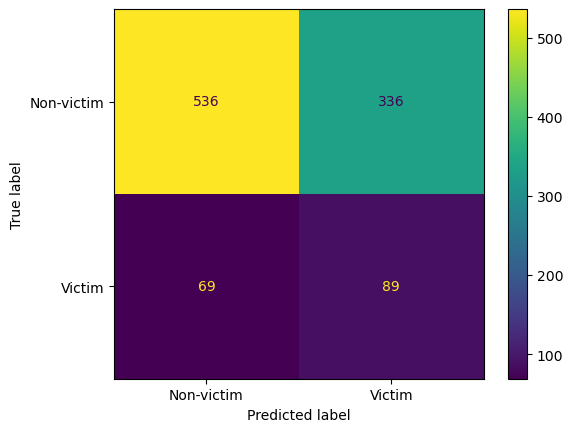

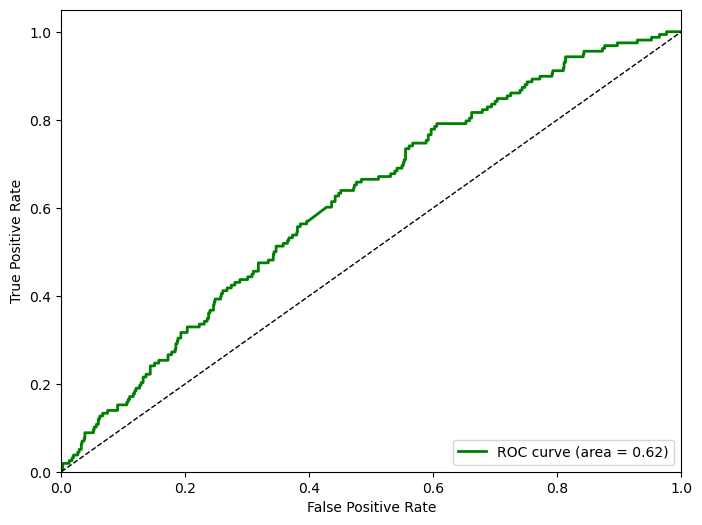

In [228]:
#optuna optimalisation voor svm and gsmote

def objective(trial):
    # Suggest values for the hyperparameters
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'sigmoid', 'poly'])
    C = trial.suggest_float('C', 1e-6, 1e2, log=True)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

    # Additional parameters for 'poly' and 'sigmoid'
    coef0 = trial.suggest_float('coef0', 0, 1, step = 0.1) if kernel in ['sigmoid', 'poly'] else 0.0

    # Create the SVM classifier
    classifier = svm.SVC(kernel=kernel, C=C, gamma=gamma, coef0=coef0, random_state=random_state)

    # Create a pipeline
    pipeline = IMBPipeline([
        ('gsmotenc', gsmotenc),
        ('classifier', classifier)
    ])

    # Cross-validation within the trial
    skf = StratifiedKFold(n_splits=5)
    scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_valid_fold)
        score = f1_score(y_valid_fold, preds, average='binary')  # Ensure appropriate average method
        scores.append(score)

    return np.mean(scores)

#pruner = MedianPruner()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
classifier = svm.SVC(**best_params, probability=True, random_state=random_state)
best_pipeline = IMBPipeline([
    ('gsmotenc', gsmotenc),
    ('classifier', classifier)
])

best_pipeline.fit(X_train, y_train)

predictions = best_pipeline.predict(X_test)
probabilities = best_pipeline.predict_proba(X_test)[:, 1]

y_pred = predictions
evalution(y_test, y_pred, probabilities)

[I 2024-06-17 11:56:08,463] A new study created in memory with name: no-name-6d03e441-8b45-4a30-bd8d-dfc80046ba18
[I 2024-06-17 11:57:58,501] Trial 0 finished with value: 0.26567076123126 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'auto', 'leaf_size': 50, 'p': 1}. Best is trial 0 with value: 0.26567076123126.
[I 2024-06-17 11:59:50,671] Trial 1 finished with value: 0.26337806717854717 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'auto', 'leaf_size': 45, 'p': 2}. Best is trial 0 with value: 0.26567076123126.
[I 2024-06-17 12:01:41,810] Trial 2 finished with value: 0.2675066082414391 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree', 'leaf_size': 30, 'p': 2}. Best is trial 2 with value: 0.2675066082414391.
[I 2024-06-17 12:03:31,938] Trial 3 finished with value: 0.210072495443199 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'ball_tree', 'leaf_size': 30, 'p': 1}. Best is trial 

Best trial:
 Value: 0.2732224383164913
 Params: 
    n_neighbors: 10
    weights: uniform
    algorithm: auto
    leaf_size: 50
    p: 1
Accuracy: 0.470873786407767
Binary F1: 0.25648021828103684
Weighted F1 0.5382453899562573
Recall 0.5949367088607594


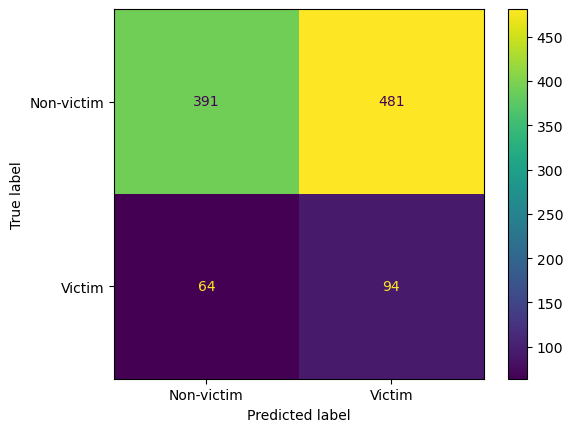

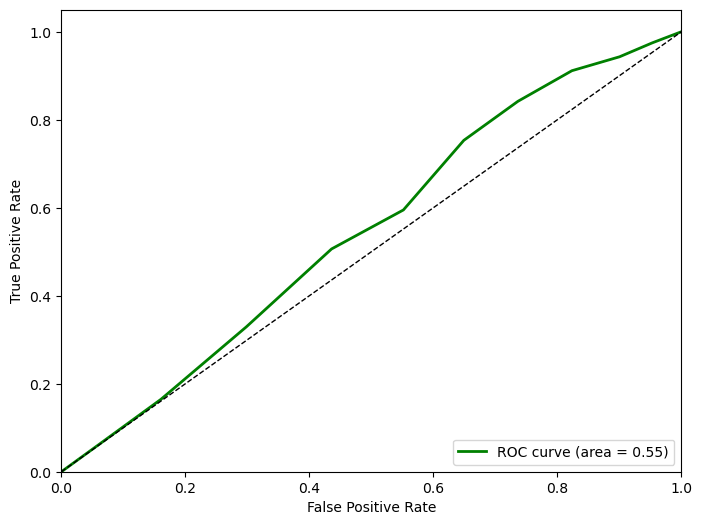

In [229]:
#optuna for knn with smote
def objective(trial):

    # parameter grid
    n_neighbors = trial.suggest_int('n_neighbors', 2, 10)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    leaf_size = trial.suggest_int('leaf_size', 20, 60, step=5)
    p = trial.suggest_categorical('p', [1, 2])

    # Set up the classifier
    classifier = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        algorithm=algorithm,
        leaf_size=leaf_size,
        p=p
    )

    # Create a pipeline
    pipeline = IMBPipeline([
        ('gsmotenc', gsmotenc),
        ('classifier', classifier)
    ])

    # Cross-validation within the trial
    skf = StratifiedKFold(n_splits=5)
    scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_valid_fold)
        score = f1_score(y_valid_fold, preds, average='binary')  # Ensure appropriate average method
        scores.append(score)

    return np.mean(scores)

#pruner = MedianPruner()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
classifier = KNeighborsClassifier(**best_params)
best_pipeline = IMBPipeline([
    ('gsmotenc', gsmotenc),
    ('classifier', classifier)
])

best_pipeline.fit(X_train, y_train)

predictions = best_pipeline.predict(X_test)
probabilities = best_pipeline.predict_proba(X_test)[:, 1]

y_pred = predictions
evalution(y_test, y_pred, probabilities)

# Exclusion of RA parameters (only personal)

In [158]:
#load data again
df = pd.read_csv('binary_task.csv')

parameters = df.drop('all', axis=1)
y = df['all']

parameters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5150 entries, 0 to 5149
Data columns (total 48 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   geslacht  5150 non-null   int64
 1   leeftijd  5150 non-null   int64
 2   aantalki  5150 non-null   int64
 3   oplcat    5150 non-null   int64
 4   ac18f092  5150 non-null   int64
 5   ac18f007  5150 non-null   int64
 6   ac18f036  5150 non-null   int64
 7   ac18f045  5150 non-null   int64
 8   ac18f047  5150 non-null   int64
 9   ac18f048  5150 non-null   int64
 10  ac18f049  5150 non-null   int64
 11  ac18f051  5150 non-null   int64
 12  ac18f052  5150 non-null   int64
 13  ac18f053  5150 non-null   int64
 14  ac18f054  5150 non-null   int64
 15  ac18f066  5150 non-null   int64
 16  ac18f067  5150 non-null   int64
 17  ac18f069  5150 non-null   int64
 18  ac18f070  5150 non-null   int64
 19  ac18f071  5150 non-null   int64
 20  ac18f080  5150 non-null   int64
 21  ac18f081  5150 non-null   int64
 22  

In [159]:
#removal of RA parameters
exclude = ['ac18f036','ac18f045', 'ac18f047', 'ac18f048', 'ac18f049', 'ac18f051', 'ac18f052', 'ac18f053', 'ac18f054', 'cs17j251', 'cs17j252', 'cs17j253', 'cs17j254', 'cs17j429', 'cs17j430', 'cs17j260', 'cs17j261', 'cs17j262', 'cs17j263', 'cs17j431', 'cs17j432', 'cs17j486', 'cs17j264', 'cs17j435', 'cs17j265', 'cs17j266']

RA_parameters = parameters.drop(exclude, axis=1)
RA_parameters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5150 entries, 0 to 5149
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   geslacht  5150 non-null   int64
 1   leeftijd  5150 non-null   int64
 2   aantalki  5150 non-null   int64
 3   oplcat    5150 non-null   int64
 4   ac18f092  5150 non-null   int64
 5   ac18f007  5150 non-null   int64
 6   ac18f066  5150 non-null   int64
 7   ac18f067  5150 non-null   int64
 8   ac18f069  5150 non-null   int64
 9   ac18f070  5150 non-null   int64
 10  ac18f071  5150 non-null   int64
 11  ac18f080  5150 non-null   int64
 12  ac18f081  5150 non-null   int64
 13  ac18f082  5150 non-null   int64
 14  ac18f083  5150 non-null   int64
 15  ac18f084  5150 non-null   int64
 16  ac18f085  5150 non-null   int64
 17  ac18f087  5150 non-null   int64
 18  ac18f088  5150 non-null   int64
 19  ac18f089  5150 non-null   int64
 20  ac18f090  5150 non-null   int64
 21  ac18f091  5150 non-null   int64
dtype

In [160]:
#preprocess certain parameters
onehot_cols = ['ac18f092', 'ac18f007', 'ac18f066', 'ac18f067', 'ac18f069', 'ac18f070', 'ac18f071', 'ac18f080', 'ac18f081', 'ac18f082', 'ac18f083', 'ac18f084', 'ac18f085', 'ac18f087', 'ac18f088', 'ac18f089', 'ac18f090', 'ac18f091']

onehot = ce.OneHotEncoder(cols= onehot_cols)

RA_parameters_onehot = onehot.fit_transform(RA_parameters)
RA_parameters_onehot.head()

geslacht  leeftijd  aantalki  oplcat  ac18f092_1  ac18f092_2  ac18f092_3  \
0         1        71         0       2           1           0           0   
1         0        64         0       2           1           0           0   
2         0        41         0       4           1           0           0   
3         1        64         0       4           1           0           0   
4         1        78         0       2           1           0           0   

   ac18f092_4  ac18f092_5  ac18f092_6  ...  ac18f088_3  ac18f089_1  \
0           0           0           0  ...           0           1   
1           0           0           0  ...           0           1   
2           0           0           0  ...           0           1   
3           0           0           0  ...           0           1   
4           0           0           0  ...           0           1   

   ac18f089_2  ac18f089_3  ac18f090_1  ac18f090_2  ac18f090_3  ac18f091_1  \
0           0           0           1           0           0           1   
1           0           0           1           0           0           1   
2           0           0           1           0           0           0   
3           0           0           1           0           0           0   
4           0           0           1           0           0           1   

   ac18f091_2  ac18f091_3  
0           0           0  
1           0           0  
2           1           0  
3           0           1  
4           0           0  

[5 rows x 74 columns]

In [ ]:
#initialise ROS again
ros = RandomOverSampler(random_state=random_state)

In [161]:
X_train_RA, X_test_RA, y_train_RA, y_test_RA = train_test_split(RA_parameters_onehot, y, test_size=0.2, stratify= y, random_state=random_state)
X_train_RA.head()

geslacht  leeftijd  aantalki  oplcat  ac18f092_1  ac18f092_2  \
1297         0        20         0       3           1           0   
5066         1        30         4       1           0           0   
4500         1        45         2       4           0           1   
383          0        64         0       2           1           0   
863          0        73         0       5           1           0   

      ac18f092_3  ac18f092_4  ac18f092_5  ac18f092_6  ...  ac18f088_3  \
1297           0           0           0           0  ...           0   
5066           0           0           0           0  ...           0   
4500           0           0           0           0  ...           0   
383            0           0           0           0  ...           0   
863            0           0           0           0  ...           0   

      ac18f089_1  ac18f089_2  ac18f089_3  ac18f090_1  ac18f090_2  ac18f090_3  \
1297           1           0           0           1           0           0   
5066           0           1           0           0           1           0   
4500           0           1           0           0           0           1   
383            1           0           0           1           0           0   
863            1           0           0           1           0           0   

      ac18f091_1  ac18f091_2  ac18f091_3  
1297           1           0           0  
5066           1           0           0  
4500           0           0           1  
383            1           0           0  
863            1           0           0  

[5 rows x 74 columns]

[I 2024-06-20 13:05:28,554] A new study created in memory with name: no-name-53bebe4a-307b-4c25-8d52-1a185b0d4424
c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\samsm\anaconda3\envs\Thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the

Best trial:
 Value: 0.29836495383541256
 Params: 
    solver: lbfgs
    C: 0.00023756579377722534
    max_iter: 100
    warm_start: False
Accuracy: 0.5912621359223301
Binary F1: 0.3018242122719735
Weighted F1 0.6482756459344456
Recall 0.5759493670886076


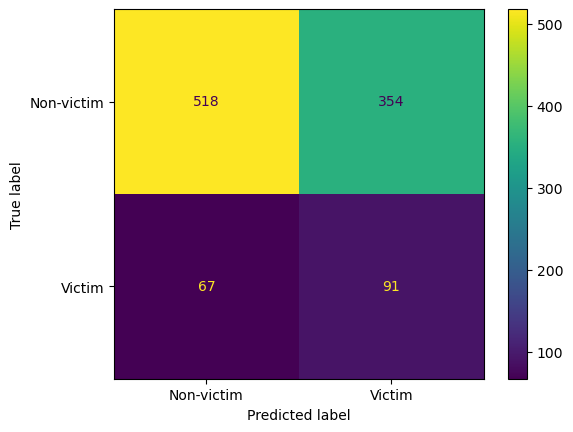

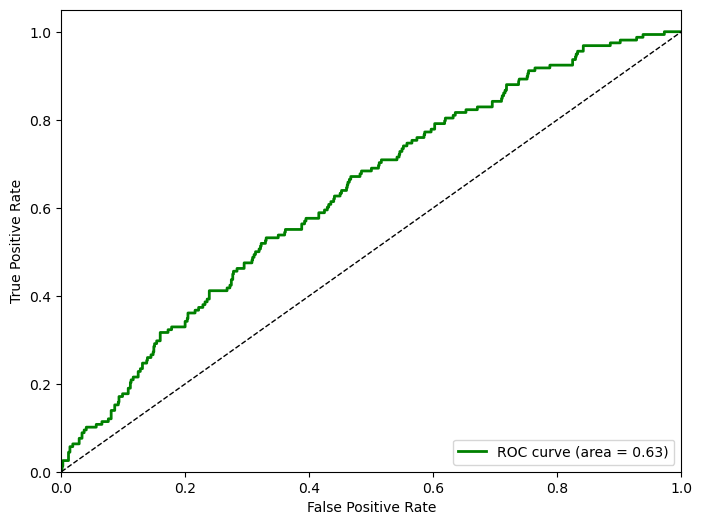

In [162]:
def objective(trial):
    # Suggest values for the hyperparameters
    solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cg'])
    C = trial.suggest_float('C', 1e-6, 1e2, log = True)
    max_iter = trial.suggest_int('max_iter', 100, 800, step = 50)
    warm_start = trial.suggest_categorical('warm_start', [True, False])

    # Create the classifier with suggested parameters
    classifier = LogisticRegression(solver=solver, C=C, max_iter=max_iter, warm_start=warm_start, random_state=random_state)
    
    # Create a pipeline
    pipeline = IMBPipeline([
        ('smote', ros),
        ('classifier', classifier)
    ])

    # Cross-validation within the trial
    skf = StratifiedKFold(n_splits=5)
    scores = []

    for train_idx, valid_idx in skf.split(X_train_RA, y_train_RA):
        X_train_fold, X_valid_fold = X_train_RA.iloc[train_idx], X_train_RA.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train_RA.iloc[train_idx], y_train_RA.iloc[valid_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_valid_fold)
        score = f1_score(y_valid_fold, preds, average='binary')  # Ensure appropriate average method
        scores.append(score)

    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
best_classifier = LogisticRegression(**best_params, random_state=random_state)
best_pipeline = IMBPipeline([
    ('smote', ros),
    ('classifier', best_classifier)
])

best_pipeline.fit(X_train_RA, y_train_RA)

predictions = best_pipeline.predict(X_test_RA)
probabilities = best_pipeline.predict_proba(X_test_RA)[:, 1]

y_pred = predictions
evalution(y_test_RA, y_pred, probabilities)

# exclusion of PC parameters (Add RA)
As the data has already been loaded again, it does not need to happen again.

In [163]:
parameters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5150 entries, 0 to 5149
Data columns (total 48 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   geslacht  5150 non-null   int64
 1   leeftijd  5150 non-null   int64
 2   aantalki  5150 non-null   int64
 3   oplcat    5150 non-null   int64
 4   ac18f092  5150 non-null   int64
 5   ac18f007  5150 non-null   int64
 6   ac18f036  5150 non-null   int64
 7   ac18f045  5150 non-null   int64
 8   ac18f047  5150 non-null   int64
 9   ac18f048  5150 non-null   int64
 10  ac18f049  5150 non-null   int64
 11  ac18f051  5150 non-null   int64
 12  ac18f052  5150 non-null   int64
 13  ac18f053  5150 non-null   int64
 14  ac18f054  5150 non-null   int64
 15  ac18f066  5150 non-null   int64
 16  ac18f067  5150 non-null   int64
 17  ac18f069  5150 non-null   int64
 18  ac18f070  5150 non-null   int64
 19  ac18f071  5150 non-null   int64
 20  ac18f080  5150 non-null   int64
 21  ac18f081  5150 non-null   int64
 22  

In [164]:
#Removal of pc
exclude = ['geslacht', 'leeftijd', 'aantalki', 'oplcat', 'ac18f092', 'ac18f007']
SC_parameters = parameters.drop(exclude, axis=1)
SC_parameters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5150 entries, 0 to 5149
Data columns (total 42 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   ac18f036  5150 non-null   int64
 1   ac18f045  5150 non-null   int64
 2   ac18f047  5150 non-null   int64
 3   ac18f048  5150 non-null   int64
 4   ac18f049  5150 non-null   int64
 5   ac18f051  5150 non-null   int64
 6   ac18f052  5150 non-null   int64
 7   ac18f053  5150 non-null   int64
 8   ac18f054  5150 non-null   int64
 9   ac18f066  5150 non-null   int64
 10  ac18f067  5150 non-null   int64
 11  ac18f069  5150 non-null   int64
 12  ac18f070  5150 non-null   int64
 13  ac18f071  5150 non-null   int64
 14  ac18f080  5150 non-null   int64
 15  ac18f081  5150 non-null   int64
 16  ac18f082  5150 non-null   int64
 17  ac18f083  5150 non-null   int64
 18  ac18f084  5150 non-null   int64
 19  ac18f085  5150 non-null   int64
 20  ac18f087  5150 non-null   int64
 21  ac18f088  5150 non-null   int64
 22  

In [165]:
#preprocess/onehot certain columns
onehot_cols = ['ac18f045', 'ac18f066', 'ac18f067', 'ac18f069', 'ac18f070', 'ac18f071']

onehot = ce.OneHotEncoder(cols= onehot_cols)

SC_parameters = onehot.fit_transform(SC_parameters)
SC_parameters.head()

ac18f036  ac18f045_1  ac18f045_2  ac18f045_3  ac18f045_4  ac18f045_5  \
0         1           1           0           0           0           0   
1         1           1           0           0           0           0   
2         1           0           1           0           0           0   
3         7           1           0           0           0           0   
4         1           1           0           0           0           0   

   ac18f047  ac18f048  ac18f049  ac18f051  ...  cs17j261  cs17j262  cs17j263  \
0         5         5         3         5  ...         1         1         1   
1         4         5         4         4  ...         1         0         1   
2         4         3         3         2  ...         0         1         0   
3         5         5         4         5  ...         0         0         0   
4         4         2         2         4  ...         0         0         0   

   cs17j431  cs17j432  cs17j486  cs17j264  cs17j435  cs17j265  cs17j266  
0         1         0         1         0         0         0         0  
1         0         0         0         1         0         0         0  
2         1         0         0         1         1         0         1  
3         1         0         0         1         0         0         1  
4         1         0         0         0         0         0         0  

[5 rows x 61 columns]

In [166]:
X_train_SC, X_test_SC, y_train_SC, y_test_SC = train_test_split(SC_parameters, y, test_size=0.2, stratify= y, random_state=random_state)
X_train_SC.head()

ac18f036  ac18f045_1  ac18f045_2  ac18f045_3  ac18f045_4  ac18f045_5  \
1297         3           0           1           0           0           0   
5066         1           1           0           0           0           0   
4500         8           0           1           0           0           0   
383          2           1           0           0           0           0   
863          3           0           0           0           1           0   

      ac18f047  ac18f048  ac18f049  ac18f051  ...  cs17j261  cs17j262  \
1297         2         3         3         3  ...         0         0   
5066         4         4         4         3  ...         1         0   
4500         4         5         4         5  ...         0         0   
383          5         0         3         5  ...         0         0   
863          3         4         3         4  ...         0         1   

      cs17j263  cs17j431  cs17j432  cs17j486  cs17j264  cs17j435  cs17j265  \
1297         0         1         0         1         1         1         0   
5066         0         1         1         0         0         0         0   
4500         0         1         0         1         1         0         0   
383          0         0         0         0         0         0         0   
863          1         1         1         1         1         0         1   

      cs17j266  
1297         1  
5066         0  
4500         1  
383          0  
863          0  

[5 rows x 61 columns]

[I 2024-06-20 13:06:44,225] A new study created in memory with name: no-name-1050bb2b-0af8-4788-a4bb-849d6deabf00
[I 2024-06-20 13:06:44,574] Trial 0 finished with value: 0.2887953356226552 and parameters: {'solver': 'newton-cg', 'C': 1.4523116572873995e-05, 'max_iter': 500, 'warm_start': True}. Best is trial 0 with value: 0.2887953356226552.
[I 2024-06-20 13:06:44,887] Trial 1 finished with value: 0.2883680234722291 and parameters: {'solver': 'newton-cg', 'C': 3.2943418623044113e-06, 'max_iter': 150, 'warm_start': True}. Best is trial 0 with value: 0.2887953356226552.
[I 2024-06-20 13:06:45,263] Trial 2 finished with value: 0.3180883457388188 and parameters: {'solver': 'newton-cg', 'C': 0.040669950918938935, 'max_iter': 200, 'warm_start': False}. Best is trial 2 with value: 0.3180883457388188.
[I 2024-06-20 13:06:45,542] Trial 3 finished with value: 0.3056965380816733 and parameters: {'solver': 'lbfgs', 'C': 0.00017971881194395214, 'max_iter': 800, 'warm_start': True}. Best is trial 2

Best trial:
 Value: 0.3227089217135547
 Params: 
    solver: newton-cg
    C: 0.001697958181835193
    max_iter: 250
    warm_start: False
Accuracy: 0.658252427184466
Binary F1: 0.36462093862815886
Weighted F1 0.7046563410466181
Recall 0.6392405063291139


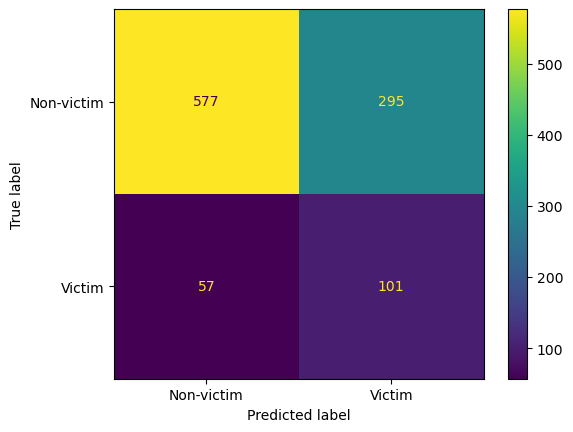

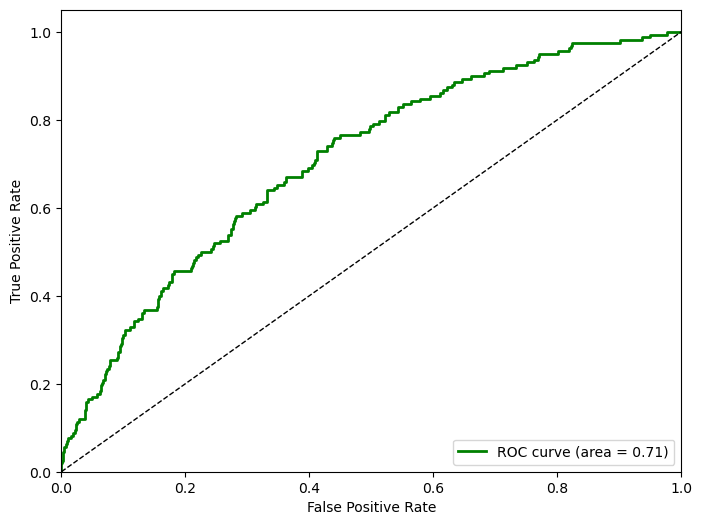

In [173]:
def objective(trial):
    # Suggest values for the hyperparameters
    solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cg'])
    C = trial.suggest_float('C', 1e-6, 1e2, log = True)
    max_iter = trial.suggest_int('max_iter', 100, 800, step = 50)
    warm_start = trial.suggest_categorical('warm_start', [True, False])

    # Create the classifier with suggested parameters
    classifier = LogisticRegression(solver=solver, C=C, max_iter=max_iter, warm_start=warm_start, random_state=random_state)
    
    # Create a pipeline
    pipeline = IMBPipeline([
        ('smote', ros),
        ('classifier', classifier)
    ])

    # Cross-validation within the trial
    skf = StratifiedKFold(n_splits=5)
    scores = []

    for train_idx, valid_idx in skf.split(X_train_SC, y_train_SC):
        X_train_fold, X_valid_fold = X_train_SC.iloc[train_idx], X_train_SC.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train_SC.iloc[train_idx], y_train_SC.iloc[valid_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_valid_fold)
        score = f1_score(y_valid_fold, preds, average='binary')  # Ensure appropriate average method
        scores.append(score)

    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
best_classifier = LogisticRegression(**best_params, random_state=random_state)
best_pipeline = IMBPipeline([
    ('smote', ros),
    ('classifier', best_classifier)
])

best_pipeline.fit(X_train_SC, y_train_SC)

predictions = best_pipeline.predict(X_test_SC)
probabilities = best_pipeline.predict_proba(X_test_SC)[:, 1]

y_pred = predictions
evalution(y_test_SC, y_pred, probabilities)

# Removal of both RA and personal characteristics as a base model

In [168]:
#removal of RA and pC
exclude = ['geslacht', 'leeftijd', 'aantalki', 'oplcat', 'ac18f092', 'ac18f007', 'ac18f036', 'ac18f045', 'ac18f047', 'ac18f048', 'ac18f049', 'ac18f051', 'ac18f052', 'ac18f053', 'ac18f054', 'cs17j251', 'cs17j252', 'cs17j253', 'cs17j254', 'cs17j429', 'cs17j430', 'cs17j260', 'cs17j261', 'cs17j262', 'cs17j263', 'cs17j431', 'cs17j432', 'cs17j486', 'cs17j264', 'cs17j435', 'cs17j265', 'cs17j266']
baseline = parameters.drop(exclude, axis=1)
baseline.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5150 entries, 0 to 5149
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   ac18f066  5150 non-null   int64
 1   ac18f067  5150 non-null   int64
 2   ac18f069  5150 non-null   int64
 3   ac18f070  5150 non-null   int64
 4   ac18f071  5150 non-null   int64
 5   ac18f080  5150 non-null   int64
 6   ac18f081  5150 non-null   int64
 7   ac18f082  5150 non-null   int64
 8   ac18f083  5150 non-null   int64
 9   ac18f084  5150 non-null   int64
 10  ac18f085  5150 non-null   int64
 11  ac18f087  5150 non-null   int64
 12  ac18f088  5150 non-null   int64
 13  ac18f089  5150 non-null   int64
 14  ac18f090  5150 non-null   int64
 15  ac18f091  5150 non-null   int64
dtypes: int64(16)
memory usage: 643.9 KB


In [169]:
#preprocess/onehot certain columns
onehot_cols = ['ac18f066', 'ac18f067', 'ac18f069', 'ac18f070', 'ac18f071']

onehot = ce.OneHotEncoder(cols= onehot_cols)

baseline = onehot.fit_transform(baseline)
baseline.head()

ac18f066_1  ac18f066_2  ac18f066_3  ac18f066_4  ac18f067_1  ac18f067_2  \
0           1           0           0           0           1           0   
1           1           0           0           0           0           1   
2           0           1           0           0           1           0   
3           1           0           0           0           1           0   
4           0           1           0           0           1           0   

   ac18f067_3  ac18f067_4  ac18f069_1  ac18f069_2  ...  ac18f081  ac18f082  \
0           0           0           1           0  ...         2         1   
1           0           0           1           0  ...         2         1   
2           0           0           1           0  ...         2         1   
3           0           0           0           1  ...         2         1   
4           0           0           1           0  ...         2         1   

   ac18f083  ac18f084  ac18f085  ac18f087  ac18f088  ac18f089  ac18f090  \
0         1         1         1         1         1         2         2   
1         1         1         1         1         1         2         2   
2         1         1         1         1         1         2         2   
3         1         1         1         1         1         2         2   
4         1         1         1         1         1         2         2   

   ac18f091  
0         1  
1         1  
2         3  
3         2  
4         1  

[5 rows x 31 columns]

In [171]:
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(baseline, y, test_size=0.2, stratify= y, random_state=random_state)
X_train_base.head()

ac18f066_1  ac18f066_2  ac18f066_3  ac18f066_4  ac18f067_1  ac18f067_2  \
1297           1           0           0           0           1           0   
5066           1           0           0           0           1           0   
4500           0           0           1           0           0           0   
383            0           0           1           0           0           0   
863            1           0           0           0           1           0   

      ac18f067_3  ac18f067_4  ac18f069_1  ac18f069_2  ...  ac18f081  ac18f082  \
1297           0           0           1           0  ...         2         1   
5066           0           0           0           0  ...         3         1   
4500           1           0           0           0  ...         2         1   
383            1           0           0           0  ...         2         1   
863            0           0           0           1  ...         2         1   

      ac18f083  ac18f084  ac18f085  ac18f087  ac18f088  ac18f089  ac18f090  \
1297         1         1         1         1         1         2         2   
5066         1         1         1         1         1         1         3   
4500         1         1         1         1         1         1         1   
383          1         1         1         1         1         2         2   
863          1         1         1         1         1         2         2   

      ac18f091  
1297         1  
5066         1  
4500         2  
383          1  
863          1  

[5 rows x 31 columns]

[I 2024-06-20 13:06:16,917] A new study created in memory with name: no-name-a727c2f2-771b-45f9-9c55-215658cda1be
[I 2024-06-20 13:06:17,117] Trial 0 finished with value: 0.2576131857442624 and parameters: {'solver': 'lbfgs', 'C': 0.8647079648290028, 'max_iter': 400, 'warm_start': True}. Best is trial 0 with value: 0.2576131857442624.
[I 2024-06-20 13:06:17,269] Trial 1 finished with value: 0.2742097318006572 and parameters: {'solver': 'lbfgs', 'C': 4.228204402455939e-06, 'max_iter': 650, 'warm_start': True}. Best is trial 1 with value: 0.2742097318006572.
[I 2024-06-20 13:06:17,462] Trial 2 finished with value: 0.2588027055287112 and parameters: {'solver': 'newton-cg', 'C': 0.52398031578865, 'max_iter': 700, 'warm_start': True}. Best is trial 1 with value: 0.2742097318006572.
[I 2024-06-20 13:06:17,664] Trial 3 finished with value: 0.2694392588054596 and parameters: {'solver': 'newton-cg', 'C': 0.0009916391619996959, 'max_iter': 600, 'warm_start': False}. Best is trial 1 with value: 0

Best trial:
 Value: 0.2759356866039262
 Params: 
    solver: lbfgs
    C: 1.7425103219905147e-05
    max_iter: 600
    warm_start: True
Accuracy: 0.6689320388349514
Binary F1: 0.3111111111111111
Weighted F1 0.7098585219420233
Recall 0.4873417721518987


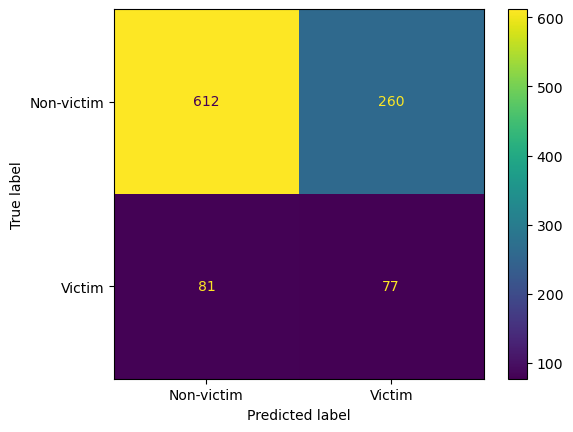

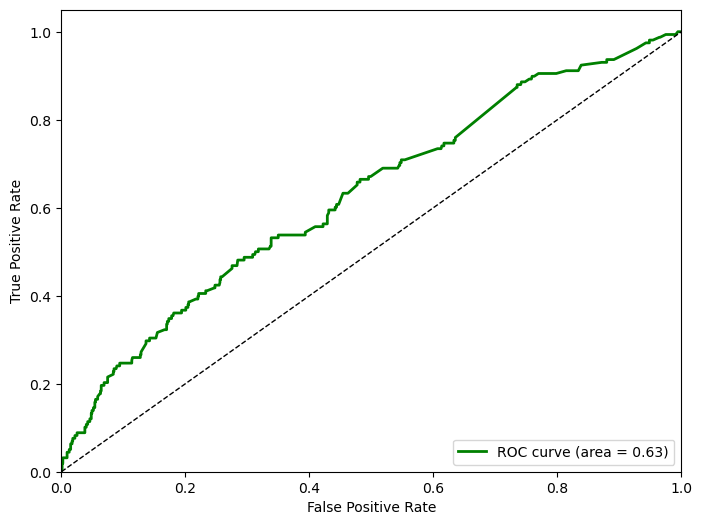

In [172]:
#optuna with LR
def objective(trial):
    # Suggest values for the hyperparameters
    solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cg'])
    C = trial.suggest_float('C', 1e-6, 1e2, log = True)
    max_iter = trial.suggest_int('max_iter', 100, 800, step = 50)
    warm_start = trial.suggest_categorical('warm_start', [True, False])

    # Create the classifier with suggested parameters
    classifier = LogisticRegression(solver=solver, C=C, max_iter=max_iter, warm_start=warm_start, random_state=random_state)
    
    # Create a pipeline
    pipeline = IMBPipeline([
        ('smote', ros),
        ('classifier', classifier)
    ])

    # Cross-validation within the trial
    skf = StratifiedKFold(n_splits=5)
    scores = []

    for train_idx, valid_idx in skf.split(X_train_base, y_train_base):
        X_train_fold, X_valid_fold = X_train_base.iloc[train_idx], X_train_base.iloc[valid_idx]
        y_train_fold, y_valid_fold = y_train_base.iloc[train_idx], y_train_base.iloc[valid_idx]

        pipeline.fit(X_train_fold, y_train_fold)
        preds = pipeline.predict(X_valid_fold)
        score = f1_score(y_valid_fold, preds, average='binary')  # Ensure appropriate average method
        scores.append(score)

    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best trial results
print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

best_params = trial.params
best_classifier = LogisticRegression(**best_params, random_state=random_state)
best_pipeline = IMBPipeline([
    ('smote', ros),
    ('classifier', best_classifier)
])

best_pipeline.fit(X_train_base, y_train_base)

predictions = best_pipeline.predict(X_test_base)
probabilities = best_pipeline.predict_proba(X_test_base)[:, 1]

y_pred = predictions
evalution(y_test_base, y_pred, probabilities)